<a href="https://colab.research.google.com/github/vxcthinh-gv/RUL_CMAPSS/blob/main/Final_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Remaining Useful Life Estimation Via Transformer Encoder Enhanced By A Gated Convolutional Unit

Báo cáo đồ án: Python cho Khoa học dữ liệu

Lớp 23TTH. Khoa Toán - Tin học

Giảng viên bộ môn: ThS. Hà Văn Thảo

Thành viên nhóm:
1.   23110049 - Võ Xuân Cường Thịnh
2.   23110131 - Lê Thị Ngọc Anh




# 0. Giới thiệu và Mục tiêu dự án
Dự đoán Thời gian hữu ích còn lại **(Remaining Useful Lifetime)** là 1 nhiệm vụ cơ bản trong tiên lượng và quản lý sức khỏe (PHM) của các thiết bị và hệ thống công nghiệp. Nó nhằm ước tính khoảng thời gian từ thời điểm hiện tại đến khi hệ thống không còn hoạt động định. Việc dự đoán chính xác RUL giúp tránh thời gian ngừng máy đột xuất, giảm chi phí bảo trì và nâng cao năng suất.

Trước đây, các phương pháp dựa trên vật lý **(Physics-based)** là tiêu chuẩn, nhưng chúng tốn kém và phức tạp. Nên dần được thay thế bởi các phương pháp Học sâu nhờ ưu thế về dữ liệu và khả năng tổng quát hóa. Tuy nhiên, các mô hình phổ biến đều tồn tại hạn chế như: CNN bị giới hạn tầm nhìn bởi kích thước hạt nhân, RNN xử lý tuần tự chậm chạp, còn Transformer thường thiếu nhạy bén với thông tin cục bộ. Để khắc phục các hạn chế trên, dự án này đã đề xuất một phương pháp kết hợp bộ mã hóa Tranformer **(Transformer Encoder)** với Đơn vị tích chập có cổng **(Gated Convolutional Unit - GCU)** để có thể vừa bao quát toàn chuỗi, vừa nhạy bén với các đặc trưng cục bộ.

Mục tiêu chính của dự án:

1.   **Xây dựng một pipleline học sâu đầu cuối** (end-to-end deep learning pipeline): Từ tiền xử lý dữ liệu đến triển khai mô hình lai.
2.   **Huấn luyện mô hình** lai dự đoán RUL bằng bộ mã hóa Transformer và Đơn vị tích chập có cổng.
3. **Đánh giá và So sánh** hiệu suất nhiều mô hình Deep Learning khác.
4. **Thực hiện Nghiên cứu loại bỏ** (Ablation Study).



# 1. Cài đặt thư viện

In [ ]:
import os
import copy
import math
import warnings
import numpy as np
import pandas as pd

# Minh họa và trực quan hóa dữ liệu
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Tiền xử lý dữ liệu và Hỗ trợ Machine Learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Thư viện Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Tắt các cảnh báo không cần thiết và xử lý lỗi xung đột thư viện đồ họa
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Thiết lập Seed ngẫu nhiên để đảm bảo kết quả thí nghiệm có thể tái lập (Reproducibility)
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)  # Seed cho tất cả các GPU nếu có

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CMAPSSData/

Mounted at /content/drive
/content/drive/MyDrive/CMAPSSData


#2. Khám phá bộ dữ liệu CMAPSS (EDA)
[C-MAPSS](https://www.nasa.gov/intelligent-systems-division/#turbofan) (viết tắt của Commercial Modular Aero-Propulsion System Simulation) là một bộ dữ liệu nổi tiếng được cung cấp bởi Trung tâm Nghiên cứu Ames của NASA.

Động cơ được nghiên cứu là động cơ tuốc bin phản lực cánh quạt (turbofan engine - động cơ phản lực). Một động cơ turbofan có nhiều thành phần. Một số thành phần quan trọng là: Quạt (Fan), Máy nén áp suất thấp (LPC), Máy nén áp suất cao (HPC), Tuốc bin áp suất thấp (LPT), Tuốc bin áp suất cao (HPT), v.v.

Trong quá trình vận hành, sự suy thoái xảy ra ở mỗi thành phần. Nếu mức độ suy thoái ở bất kỳ thành phần nào vượt quá một ngưỡng, động cơ được coi là đã hỏng. Chúng ta không muốn động cơ phản lực bị hỏng giữa không trung. Do đó, động cơ được kiểm tra trước mỗi lần cất cánh. Đây là một hình thức bảo trì định kỳ không hiệu quả về mặt chi phí. Nhưng xét đến tính chất quan trọng của hoạt động (liên quan đến tính mạng con người), chiến lược bảo trì này là chính đáng.

Tuy nhiên, chúng ta cần một hệ thống có thể đưa ra cảnh báo sớm nếu có thứ gì đó sắp hỏng. Một cảnh báo sớm, trong nhiều trường hợp, có thể giúp chúng ta chuẩn bị cho vấn đề, nếu không muốn nói là ngăn chặn nó hoàn toàn. Mục tiêu của hệ thống bảo trì dự đoán (predictive maintenance) là dự đoán RUL (Remaining Useful Life - Thời gian sử dụng hữu ích còn lại) chính xác nhất có thể, sao cho không quá sớm cũng không quá muộn.

## Bộ dữ liệu

Trong thiết lập này, chúng ta không nghiên cứu từng động cơ một. Thay vào đó, nhiều động cơ được chạy đồng thời. Nếu ngưỡng suy thoái của bất kỳ động cơ nào bị vượt quá, động cơ đó sẽ bị tắt.

Bốn thử nghiệm khác nhau đã được thực hiện bằng cách thay đổi các chế độ lỗi và điều kiện hoạt động (tương ứng với FD001, FD002, FD003, và FD004). Với mỗi loại thử nghiệm, dữ liệu được chia thành tập huấn luyện (Training set) và tập kiểm tra (Test set).

* Tập huấn luyện (Training set): Chứa dữ liệu của các động cơ chạy cho đến khi hỏng (run-to-failure). Ví dụ: train_FD001.txt chứa dữ liệu cho 100 động cơ cho đến khi hỏng.

* Tập kiểm tra (Test set): Dữ liệu được cung cấp cho một số chu kỳ tùy ý (chưa đến lúc hỏng). Nhiệm vụ là dự đoán sau bao nhiêu chu kỳ nữa thì mỗi động cơ sẽ hỏng (đây chính là giá trị RUL).

* RUL thực tế: Giá trị RUL thực tế cho tập test được cung cấp trong tệp RUL_FD001-4.txt để đánh giá mô hình.

## 2.1 Vẽ đồ thị EDA

In [ ]:
# Đồ thị tuổi thọ động cơ
def plot_rul_distribution(df, dataset_name='Dataset'):
    """Vẽ biểu đồ phân phối tuổi thọ (Max Cycles) của các động cơ."""
    max_cycles = df.groupby('unit_nr')['time_cycles'].max()
    mean_cycle = max_cycles.mean()

    plt.figure(figsize=(10, 5))
    sns.histplot(max_cycles, kde=True, bins=30, color='skyblue')
    plt.title(f'Phân phối tuổi thọ động cơ - {dataset_name}')
    plt.xlabel('Số chu kỳ (Cycles)')
    plt.ylabel('Số lượng động cơ')
    plt.axvline(mean_cycle, color='red', linestyle='--', label=f'Trung bình: {mean_cycle:.1f}')
    plt.legend()
    plt.show()
    print(f"Tuổi thọ trung bình: {mean_cycle:.1f} chu kỳ.")

# Đồ thị nghiên cứu xu hướng hoạt động của động cơ
def plot_sensor_trends(df, unit_id=1, sensors=None):
    """
    Vẽ xu hướng của các cảm biến theo thời gian cho một động cơ cụ thể.
    Mặc định vẽ: s_2, s_3, s_4, s_7, s_11, s_12, s_14, s_15
    """
    if sensors is None:
        sensors = ['s_2', 's_3', 's_4', 's_7', 's_11', 's_12', 's_14', 's_15']

    engine_data = df[df['unit_nr'] == unit_id]

    plt.figure(figsize=(14, 8))
    plt.suptitle(f'Xu hướng cảm biến - Động cơ {unit_id}', fontsize=14)

    for i, sensor in enumerate(sensors):
        plt.subplot(2, 4, i+1)
        if sensor in df.columns:
            plt.plot(engine_data['time_cycles'], engine_data[sensor], color='green', linewidth=1)
            plt.title(sensor)
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Biểu đồ hộp
def plot_sensor_boxplots(df, start_col=5, end_col=26, n_cols_grid=3):
    """
    Vẽ biểu đồ boxplot cho các cột được chỉ định trong DataFrame.

    Tham số:
    - df: DataFrame chứa dữ liệu.
    - start_col: Chỉ số cột bắt đầu (mặc định là 5).
    - end_col: Chỉ số cột kết thúc (mặc định là 26 - không bao gồm cột này).
    - n_cols_grid: Số lượng biểu đồ trên một hàng ngang (mặc định là 3).
    """

    # Lấy danh sách các cột cần vẽ dựa trên chỉ số (index)
    columns_to_plot = df.columns[start_col:end_col]
    n_plots = len(columns_to_plot)

    # Tính toán số lượng hàng cần thiết cho grid
    n_rows_grid = math.ceil(n_plots / n_cols_grid)

    # Thiết lập kích thước hình ảnh dựa trên số hàng
    plt.figure(figsize=(15, 3 * n_rows_grid))

    for i, col_name in enumerate(columns_to_plot):
        # Tạo subplot (index bắt đầu từ 1)
        plt.subplot(n_rows_grid, n_cols_grid, i + 1)

        # Lấy dữ liệu của cột tương ứng
        data = df.iloc[:, start_col + i]

        plt.boxplot(data)
        plt.title(f"Sensor: {i + 1} (Col idx: {start_col + i})")

    plt.tight_layout() # Tự động căn chỉnh khoảng cách để không bị chồng chéo
    plt.show()

# Chế độ vận hành Scatter Plot
def plot_operating_conditions(df, dataset_name='Dataset'):
    """Vẽ Scatter plot các chế độ vận hành (Setting 1 vs Setting 2)."""
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df['setting_1'], df['setting_2'],
                          c=df['setting_3'], cmap='viridis', alpha=0.6)
    plt.title(f'Chế độ vận hành (Operating Settings) - {dataset_name}')
    plt.xlabel('Setting 1')
    plt.ylabel('Setting 2')
    plt.colorbar(scatter, label='Setting 3')
    plt.grid(True, alpha=0.3)
    plt.show()

## 2.2 Mô tả dữ liệu
Dữ liệu về cơ bản được chia làm hai loại là đơn điều kiện (FD001 và FD003) và đa điều kiện (FD002 và FD004). Để dễ minh hoạ, chúng ta sẽ phân tích và mô tả hai đại diện là FD001 và FD002.

### FD001

In [ ]:
col_names = ['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3'] + [f's_{i}' for i in range(1, 22)]
if 'df_fd001' not in locals():
    print("Đang đọc file FD001...")
    df_fd001 = pd.read_csv('train_FD001.txt', sep="\s+", header=None, names=col_names)

Đang đọc file FD001...


#### Có bao nhiêu động cơ?

In [ ]:
np.unique(df_fd001['unit_nr'])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

Vậy có 100 động cơ được lấy dữ liệu

#### Dữ liệu có cấu trúc như thế nào?

In [ ]:
df_fd001.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Dữ liệu có 26 cột và được đánh số từ 0 đến 25. Tương tự cho 3 bộ dữ liệu còn lại.

* Cột 1 (index 0): Số thứ tự động cơ (Engine ID).

* Cột 2 (index 1): Số thứ tự chu kỳ (Cycle number). Ví dụ: nếu động cơ 1 hỏng sau 192 chu kỳ, cột này sẽ chạy từ 1 đến 192.

* Cột 3, 4, 5 (index 2-4): 3 thiết lập vận hành (Operational settings).

* Cột 6-26 (index 5-25): 21 phép đo cảm biến (Sensor measurements).

In [ ]:
df_fd001.describe()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


#### Đồ thị phân bố tuổi thọ động cơ

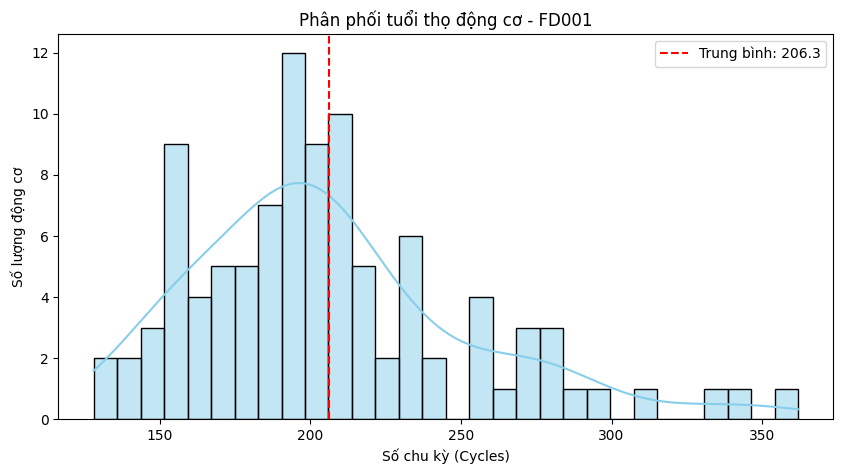

Tuổi thọ trung bình: 206.3 chu kỳ.


In [ ]:
plot_rul_distribution(df_fd001, 'FD001')

**Nhận xét:**

  * Tuổi thọ của các động cơ tuân theo dạng hình chuông (phân phối chuẩn), tập trung quanh giá trị trung bình
  * Có phương sai lớn
  * Ở các chu kỳ đầu, động cơ đang ở trạng thái "khoẻ mạnh"



#### Sau bao nhiêu chu kỳ thì động cơ bị lỗi?

In [ ]:
num_cycles_to_failure = df_fd001.groupby('unit_nr')['time_cycles'].count()
num_cycles_to_failure.values

array([192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163,
       180, 207, 209, 276, 195, 158, 234, 195, 202, 168, 147, 230, 199,
       156, 165, 163, 194, 234, 191, 200, 195, 181, 158, 170, 194, 128,
       188, 216, 196, 207, 192, 158, 256, 214, 231, 215, 198, 213, 213,
       195, 257, 193, 275, 137, 147, 231, 172, 185, 180, 174, 283, 153,
       202, 313, 199, 362, 137, 208, 213, 213, 166, 229, 210, 154, 231,
       199, 185, 240, 214, 293, 267, 188, 278, 178, 213, 217, 154, 135,
       341, 155, 258, 283, 336, 202, 156, 185, 200])

Hãy tưởng tượng một động cơ sống được 300 chu kỳ.

* Ở chu kỳ thứ 1: RUL thực tế = 299.

* Ở chu kỳ thứ 50: RUL thực tế = 250.

**Vấn đề:** Ở giai đoạn đầu (từ chu kỳ 0 đến 100), động cơ còn rất khỏe, các cảm biến gần như không thay đổi. Nếu ta bắt mô hình học con số 299 hay 250, nó sẽ bị nhiễu vì dữ liệu đầu vào không có dấu hiệu gì của sự hư hỏng cả.

**Giải pháp:** Đặt ngưỡng RUL (rul_max)

Chúng ta sử dụng mô hình **Suy giảm Tuyến tính Từng đoạn (Piecewise Linear Degradation Model)**

* Cơ chế: Trong giai đoạn đầu (một số chu kỳ đầu tiên), RUL được gán một giá trị cố định. Giá trị cố định này được gọi là RUL sớm (early RUL) hoặc giới hạn bão hòa.

* Chuyển đổi: Khi giá trị RUL thực tế giảm xuống chạm mức "RUL sớm" này, từ đó trở đi RUL mới bắt đầu tuân theo mô hình suy giảm tuyến tính về 0.

Để minh họa mô hình này, chúng ta sẽ vẽ biểu đồ giá trị RUL cho động cơ số 1:

Tổng số chu kỳ sống của động cơ 1 là 192.

Đối với mô hình tuyến tính từng đoạn, chúng ta chọn giá trị "RUL sớm" là 125. (Lưu ý: Đây chỉ là một lựa chọn ngẫu nhiên để làm ví dụ. Không có quy tắc cố định nào cho việc chọn giá trị này, nó thường dựa vào kinh nghiệm hoặc tinh chỉnh siêu tham số).

In [ ]:
engine_1_linear_degradation_model = np.arange(192-1, -1, -1)

# Piecewise_linear_degradation model
early_rul = 125
engine_1_piecewise_linear_degradation_model = np.append(early_rul*np.ones(shape = (192-early_rul,)),
                                                        np.arange(early_rul-1, -1, -1))

print("Linear degradation model shape (for engine 1): ", engine_1_linear_degradation_model.shape)
print("Piecewise linear degradation model shape (for engine 1): ", engine_1_piecewise_linear_degradation_model.shape)

Linear degradation model shape (for engine 1):  (192,)
Piecewise linear degradation model shape (for engine 1):  (192,)


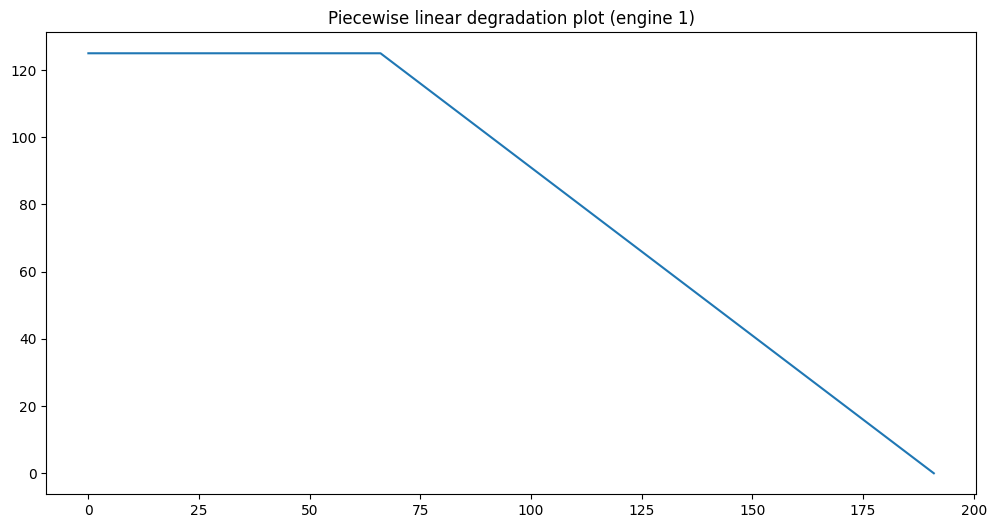

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(engine_1_piecewise_linear_degradation_model)
plt.title("Piecewise linear degradation plot (engine 1)")
plt.show()

**Nhận xét:** Đường cong suy giảm tuyến tính từng đoạn: Bắt đầu từ 125, duy trì cố định ở mức 125 trong một khoảng thời gian, và sau đó mới bắt đầu suy giảm tuyến tính về 0.

#### Các cụm chế độ vận hành

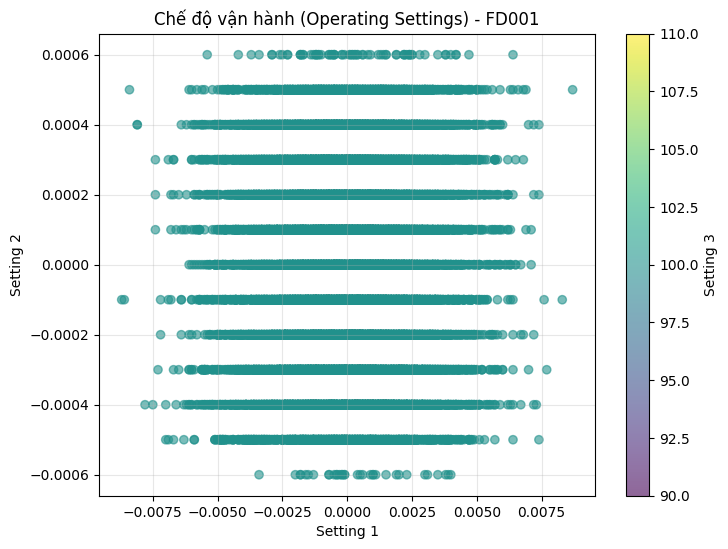

In [ ]:
# 2. Xem các cụm chế độ vận hành
plot_operating_conditions(df_fd001, 'FD001')

**Nhận xét:** Các điểm dữ liệu liền thành một dải cho thấy máy bay chỉ bay ở một điều kiện nhất định

#### Biểu đồ xu hướng hoạt động của các động cơ

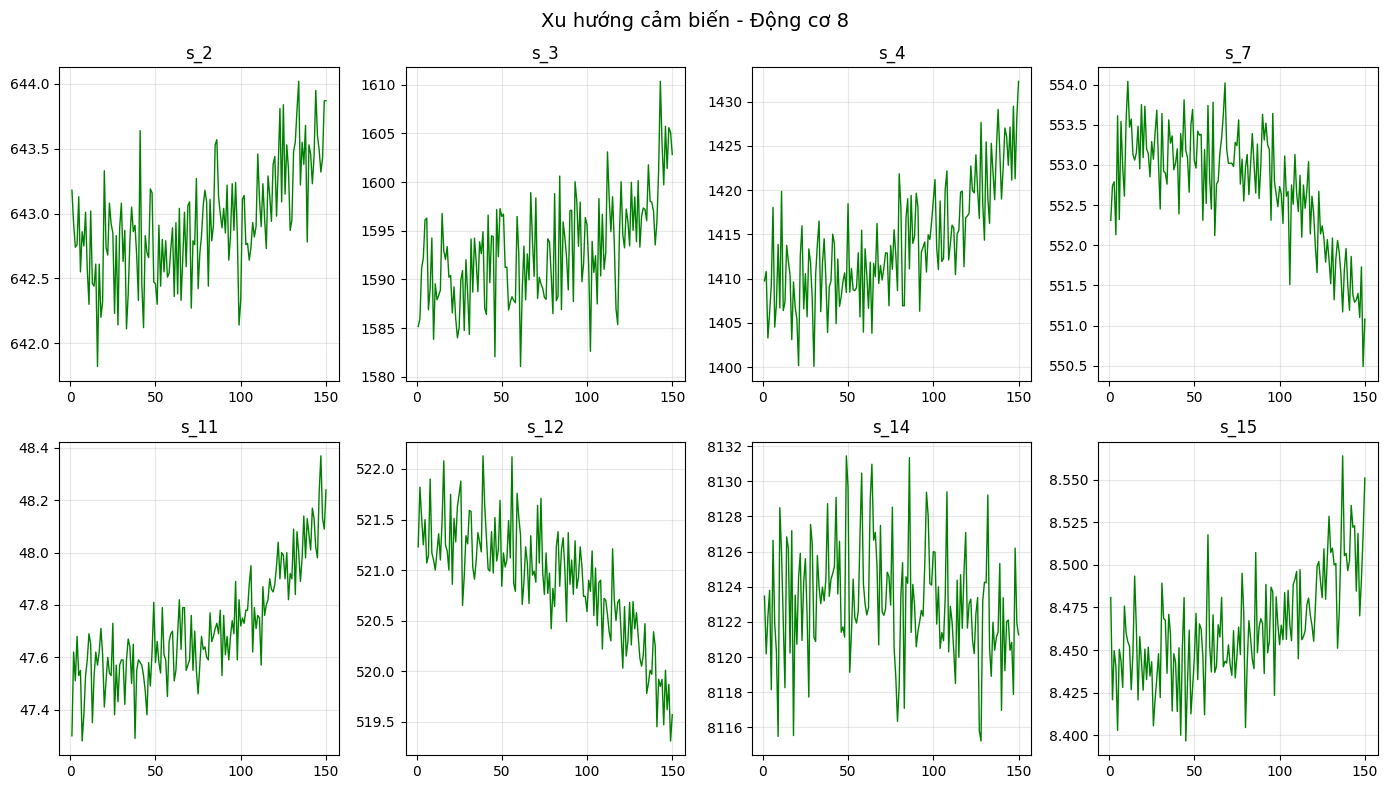

In [ ]:
plot_sensor_trends(df_fd001, unit_id=8)

#### Biểu đồ Boxplot của các số liệu đo đạc từ cảm biến:

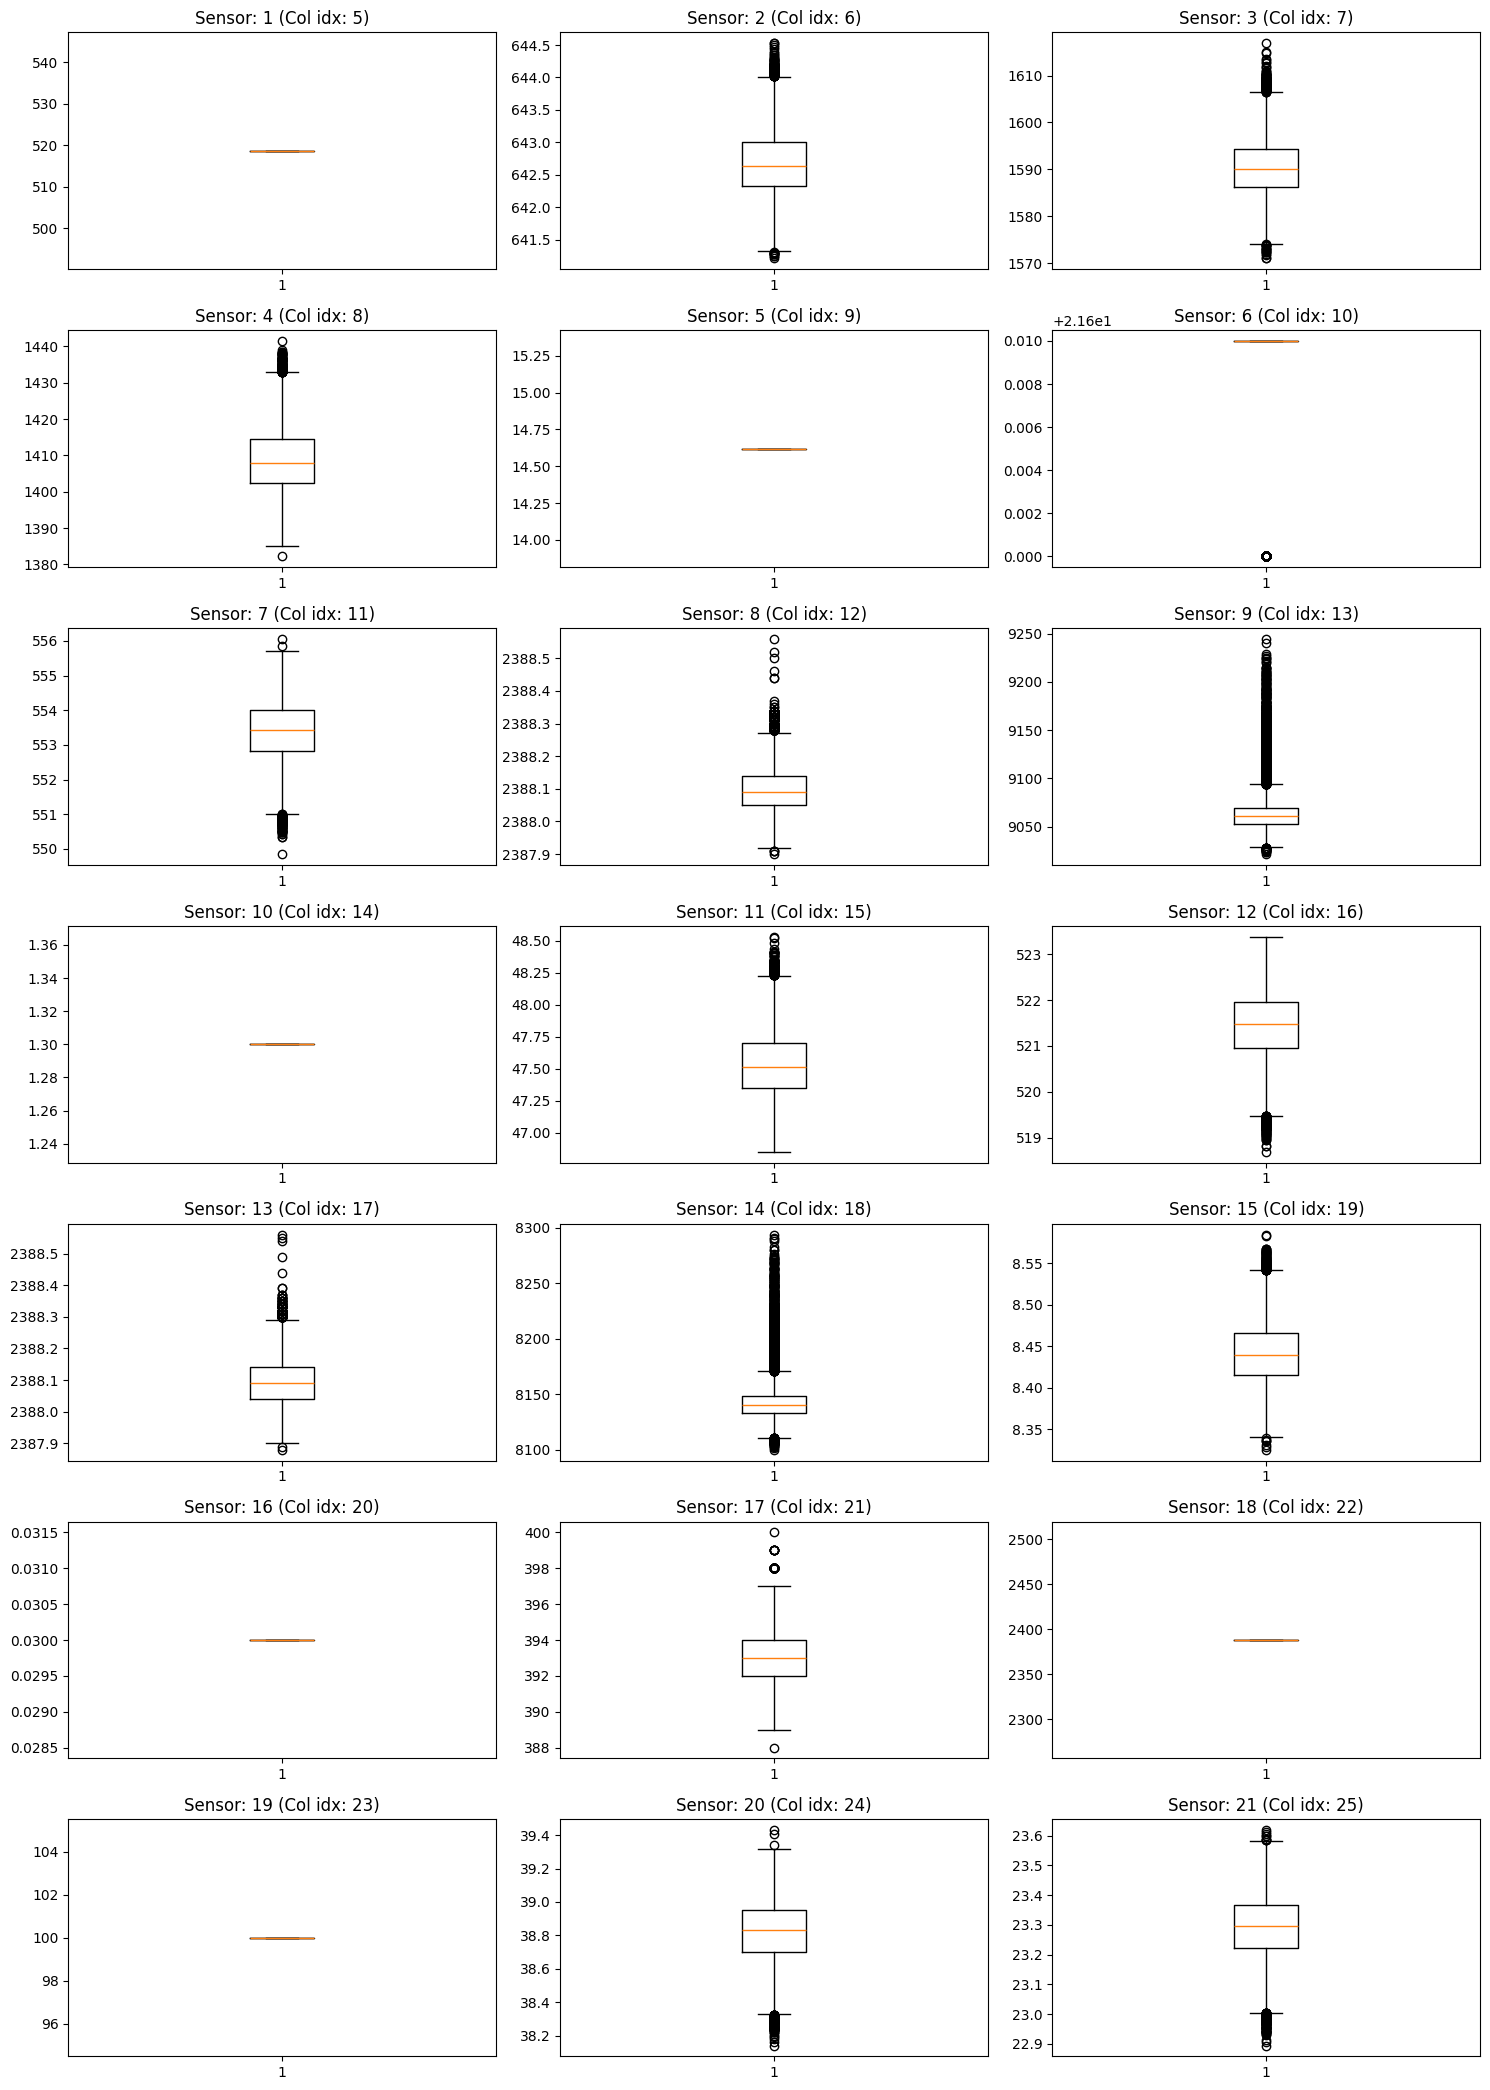

In [ ]:
plot_sensor_boxplots(df_fd001)

**Nhận xét:** Ta thấy rằng các cảm biến 1, 5, 6, 10, 16, 18, 19 là các giá trị hằng hoặc có sự thay đổi rất ít.

Do đó các giá trị này không đóng góp vào việc làm thay đổi giá trị dự báo URL nên chúng ta sẽ loại bỏ các cảm biến này khỏi tập huấn luyện để **Lựa chọn đặc trưng**.

### FD002

In [ ]:
col_names = ['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3'] + [f's_{i}' for i in range(1, 22)]
if 'df_fd002' not in locals():
    print("Đang đọc file FD002...")
    df_fd002 = pd.read_csv('train_FD002.txt', sep="\s+", header=None, names=col_names)

Đang đọc file FD002...


In [ ]:
df_fd002.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [ ]:
df_fd002.describe()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,...,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000
mean,131.082981,109.154746,23.998407,0.572056,94.046020,472.910207,579.672399,1419.971013,1205.442024,8.031986,...,266.069034,2334.557253,8066.597682,9.329654,0.023326,348.309511,2228.806358,97.756838,20.789296,12.473423
std,74.463862,69.180569,14.747376,0.310016,14.237735,26.389707,37.289399,105.946341,119.123428,3.613839,...,137.659507,128.068271,84.837950,0.749335,0.004711,27.754515,145.327980,5.364067,9.869331,5.921615
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.530000,1243.730000,1023.770000,3.910000,...,129.120000,2027.610000,7848.360000,8.335700,0.020000,303.000000,1915.000000,84.930000,10.180000,6.010500
25%,68.000000,52.000000,10.004600,0.250700,100.000000,445.000000,549.570000,1352.760000,1123.655000,3.910000,...,131.520000,2387.900000,8062.140000,8.677800,0.020000,331.000000,2212.000000,100.000000,10.910000,6.546300
50%,131.000000,104.000000,25.001300,0.700000,100.000000,462.540000,555.980000,1369.180000,1138.890000,7.050000,...,183.200000,2388.080000,8082.540000,9.310900,0.020000,335.000000,2223.000000,100.000000,14.880000,8.929200
75%,195.000000,157.000000,41.998000,0.840000,100.000000,491.190000,607.340000,1499.370000,1306.850000,10.520000,...,371.260000,2388.170000,8127.195000,9.386900,0.030000,369.000000,2324.000000,100.000000,28.470000,17.083200
max,260.000000,378.000000,42.008000,0.842000,100.000000,518.670000,644.520000,1612.880000,1439.230000,14.620000,...,523.370000,2390.480000,8268.500000,11.066900,0.030000,399.000000,2388.000000,100.000000,39.340000,23.590100


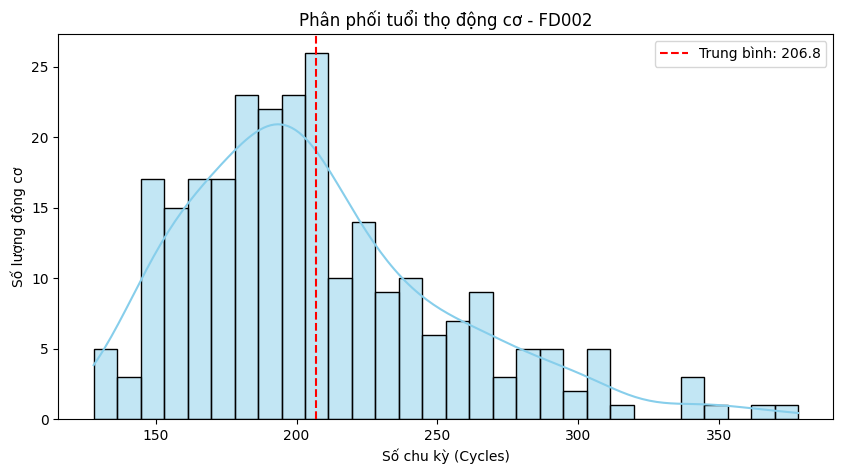

Tuổi thọ trung bình: 206.8 chu kỳ.


In [ ]:
# 1. Xem phân phối tuổi thọ
plot_rul_distribution(df_fd002, 'FD002')

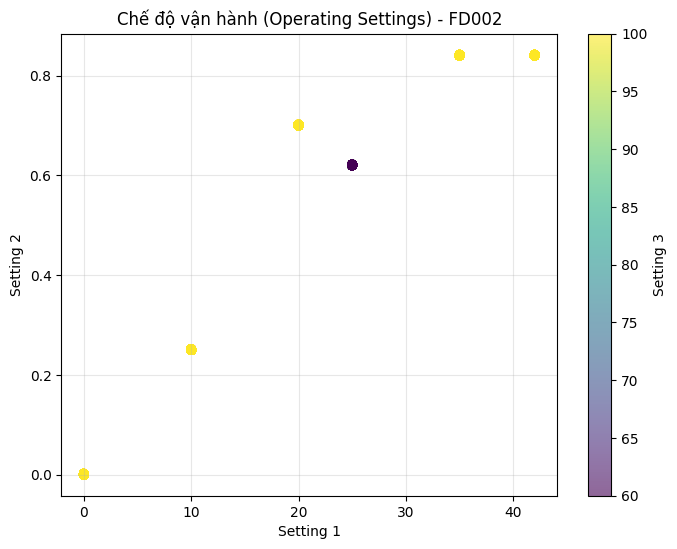

In [ ]:
# 2. Xem các cụm chế độ vận hành
plot_operating_conditions(df_fd002, 'FD002')

**Nhận xét:** Chúng ta nhận thấy các điểm dữ liệu tách rời hẳn thành 6 cụm riêng biệt thể hiện việc máy bay đang bay ở 6 điều kiện khác nhau.

Điều này gây ra sự đánh giá sai cho mô hình.

**Giải pháp:** Sử dụng thuật toán K-Means Clustering để gom cụm dữ liệu.

Việc gom cụm này giúp mô hình máy tính nhận biết động cơ đang hoạt động ở điều kiện nào giúp đánh giá công bằng hơn.

#### Biểu đồ xu hướng hoạt động của các động cơ

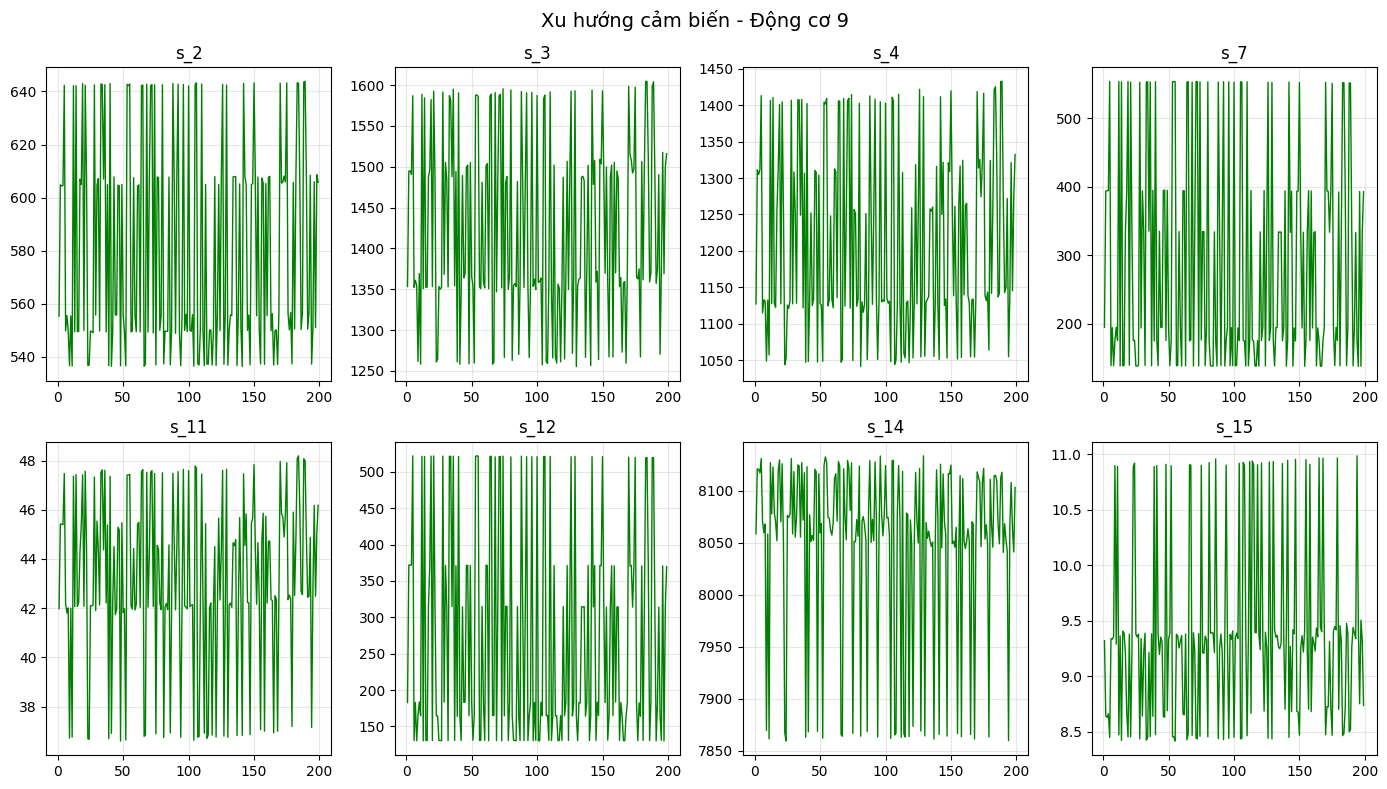

In [ ]:
plot_sensor_trends(df_fd002, unit_id=9)

## Quy trình của mô hình đánh giá

<img src = 'https://drive.google.com/uc?id=1m9jImyGMJDk6ad1DukhkOVsUcBmm5BkU' width = 600>



# 3. Cài đặt cấu hình

## 3.1 Class Config
Lớp Config tự động cấu hình các thông số xử lý cho hai loại dữ liệu là đơn điều kiện và đa điều kiện

In [ ]:
class Config:
    """Cấu hình chung cho tất cả các bộ dữ liệu"""

    # Lựa chọn bộ dữ liệu - Thay đổi biến này để chuyển đổi giữa các tập FD00x
    dataset = 'FD001'  # Tùy chọn: 'FD001', 'FD002', 'FD003', 'FD004'
    data_dir = '/content/drive/MyDrive/CMAPSSData/'

    # Thông số kiến trúc mô hình (áp dụng cho mọi bộ dữ liệu)
    d_model = 128      # Kích thước vector đặc trưng trong encoder
    n_heads = 4        # Số đầu chú ý (attention heads)
    n_layers = 2       # Số lớp encoder
    d_ff = 512         # Kích thước lớp ẩn trong tầng Feed-forward

    # Các tham số đặc thù tùy theo độ phức tạp của bộ dữ liệu
    @property
    def is_complex(self):
        """Kiểm tra nếu dữ liệu đa điều kiện vận hành (FD002, FD004)"""
        return self.dataset in ['FD002', 'FD004']

    @property
    def num_features(self):
        """Số lượng cảm biến còn lại sau khi chọn lọc"""
        return 19 if self.is_complex else 14

    @property
    def dropout(self):
        """Tỷ lệ loại bỏ (Dropout) để tránh quá khớp"""
        return 0.5 if self.is_complex else 0.1

    @property
    def sensors_to_drop(self):
        """Danh sách các cảm biến bị loại bỏ do ít biến động hoặc gây nhiễu"""
        if self.is_complex:
            # FD002/004: Chỉ loại bỏ các cảm biến có giá trị không đổi sau khi phân cụm
            return ['s_1', 's_18']
        else:
            # FD001/003: Loại bỏ các cảm biến có phương sai thấp
            return ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']

    @property
    def sequence_length(self):
      """Kích thước cửa sổ trượt (sliding window) để cắt chuỗi thời gian"""
      return 50 if self.is_complex else 30

    # Các siêu tham số huấn luyện (Hyperparameters)
    batch_size = 30
    num_epochs = 100      # Số vòng lặp tối đa (sẽ kết thúc sớm nhờ early stopping)
    learning_rate = 0.001

    # Cơ chế Dừng sớm (Early stopping) để tránh lãng phí tài nguyên và overfitting
    early_stop_patience = 15      # Dừng nếu RSME không cải thiện sau 15 epoch
    early_stop_min_delta = 0.001

    # Điều chỉnh tốc độ học (Learning rate scheduler)
    lr_patience = 3      # Giảm LR nếu RSME không giảm sau 3 epoch
    lr_factor = 0.5      # Mỗi lần giảm sẽ chia đôi tốc độ học cũ
    min_lr = 1e-6

    # Tham số RUL
    rul_max = 125

    # Số lượng cụm cho FD002 & FD004 (6 điều kiện vận hành)
    n_clusters = 6

    # Thiết bị tính toán (Sử dụng GPU nếu có, không thì dùng CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()


# Tóm tắt cấu hình hiện tại để kiểm tra trước khi chạy mô hình
target_datasets = ['FD001', 'FD002']
for ds in target_datasets:
  config.dataset = ds

  print(f"\n{'='*75}")
  print(f"Cấu hình cho {config.dataset}")
  print(f"{'='*75}")
  print(f"- Loại dữ liệu: {'PHỨC TẠP (6 điều kiện vận hành)' if config.is_complex else 'ĐƠN GIẢN (1 điều kiện vận hành)'}")
  print(f"- Số lượng cảm biến: {config.num_features}")
  print(f"- Cảm biến bị loại: {config.sensors_to_drop}")
  print(f"- Chuẩn hóa: {'Z-score theo cụm' if config.is_complex else 'Min-Max'}")
  print(f"- Tỷ lệ Dropout: {config.dropout}")
  print(f"- Độ dài cửa sổ: {config.sequence_length}")
  print(f"- Thiết bị: {config.device}")
  print(f"{'='*75}\n")


Cấu hình cho FD001
- Loại dữ liệu: ĐƠN GIẢN (1 điều kiện vận hành)
- Số lượng cảm biến: 14
- Cảm biến bị loại: ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']
- Chuẩn hóa: Min-Max
- Tỷ lệ Dropout: 0.1
- Độ dài cửa sổ: 30
- Thiết bị: cpu


Cấu hình cho FD002
- Loại dữ liệu: PHỨC TẠP (6 điều kiện vận hành)
- Số lượng cảm biến: 19
- Cảm biến bị loại: ['s_1', 's_18']
- Chuẩn hóa: Z-score theo cụm
- Tỷ lệ Dropout: 0.5
- Độ dài cửa sổ: 50
- Thiết bị: cpu



 ## 3.2 Early Stopping
 Early stopping để dừng training khi validation loss không cải thiện.

In [ ]:
# Thêm class EarlyStopping vào sau phần import
class EarlyStopping:

    """
    Dừng huấn luyện khi độ lỗi trên tập kiểm định (validation loss) không còn cải thiện.

    Tham số:
        patience: Số vòng lặp chờ đợi trước khi quyết định dừng hẳn.
        min_delta: Mức cải thiện tối thiểu để được tính là một bước cải tiến tốt.
    """

    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0          # Bộ đếm số epoch không cải thiện
        self.best_score = None    # Điểm số tốt nhất ghi nhận được
        self.early_stop = False   # Quyết định dừng hay không
        self.best_epoch = 0       # Lưu lại epoch đạt kết quả tốt nhất

    def __call__(self, val_loss, epoch):
        # Chuyển loss thành score (loss càng thấp thì score càng cao)
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
          # Nếu cải thiện tốt, cập nhật lại điểm và reset bộ đếm
            self.best_score = score
            self.best_epoch = epoch
            self.counter = 0

        return self.early_stop

# 4. Các hàm tiền xử lý dữ liệu (Pre-processing)

## 4.1. Phân cụm tập dữ liệu đa điều kiện vận hành (FD002/FD004)

Việc phân cụm bằng thuật toán **K-Means** giúp giải quyết vấn đề sai lệch dữ liệu do thay đổi chế độ hoạt động (*operational setting drift*). Dựa trên tài liệu của NASA, dữ liệu được chia thành **6 cụm** tương ứng với các chế độ bay đặc thù:

| Cụm (Cluster) | Độ cao (Alt - kft) | Tốc độ (Mach) | Góc tay ga (TRA) |
| :---: | :---: | :---: | :---: |
| **1** | 42 | 0.84 | 100 |
| **2** | 20 | 0.70 | 100 |
| **3** | 25 | 0.62 | 60 |
| **4** | 0 | 0.00 | 100 |
| **5** | 10 | 0.25 | 100 |
| **6** | 35 | 0.84 | 100 |


In [ ]:
def cluster_operating_conditions(df, n_clusters=6):
    # Trích xuất 3 thông số vận hành: Độ cao (Alt), Tốc độ (Mach), Góc tay ga (TRA)
    settings = df[['setting_1', 'setting_2', 'setting_3']].values

    # Thiết lập tâm cụm cho các chế độ vận hành khác nhau
    # Thay vì để K-Means chọn ngẫu nhiên, ta gán cứng theo 6 chế độ bay chuẩn
    init_centers = np.array([
        [42.0, 0.84, 100.0],
        [20.0, 0.70, 100.0],
        [25.0, 0.62, 60.0],
        [0.0,  0.00, 100.0],
        [10.0, 0.25, 100.0],
        [35.0, 0.84, 100.0]
    ])

    # Biểu diễn K-Means để gán mỗi dòng dữ liệu vào 1 trong 6 cụm
    kmeans = KMeans(n_clusters=6, init=init_centers, n_init=1, random_state=42)
    df['cluster'] = kmeans.fit_predict(settings)

    return df, kmeans


def apply_clustering(df, kmeans):
    """
    Áp dụng mô hình KMeans đã huấn luyện lên tập kiểm tra.
    """
    settings = df[['setting_1', 'setting_2', 'setting_3']].values
    df['cluster'] = kmeans.predict(settings)
    return df

## 4.2. Chiến lược chuẩn hóa dữ liệu

Mô hình học sâu - Transformer rất nhạy cảm với thang đo của dữ liệu đầu vào. Do đó, chúng ta xây dựng hai phương pháp chuẩn hóa riêng biệt phù hợp với đặc tính của từng bộ dữ liệu:

### 1. Chuẩn hóa Min-Max (normalize_simple_dataset)
* **Áp dụng:** Cho các tập dữ liệu **FD001** và **FD003** (chỉ có 1 điều kiện vận hành).
* **Cơ chế:** Tính toán giá trị Lớn nhất (Max) và Nhỏ nhất (Min) từ tập huấn luyện, sau đó đưa tất cả dữ liệu về khoảng $[0, 1]$.

$$x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min} + {e}}$$

<br>

### 2. Chuẩn hóa Z-score theo từng cụm (normalize_complex_dataset)
* **Áp dụng:** Cho các tập dữ liệu **FD002** và **FD004** (có 6 điều kiện vận hành phức tạp).
* **Cơ chế:**
    1. Chia dữ liệu thành các nhóm dựa trên cột `cluster` đã phân loại.
    2. Với mỗi cụm, tính toán Trung bình ($\mu$) và Độ lệch chuẩn ($\sigma$).
    3. Chuyển đổi dữ liệu về phân phối chuẩn cho mỗi cụm ($\mu_{cluster} = 0$ và $\sigma_{cluster} = 1$).

$$x_{z} = \frac{x_{cluster} - \mu_{cluster}}{\sigma_{cluster}}$$


<br>

| Phương pháp | Hàm xử lý | Tập dữ liệu | Đặc điểm |
| :--- | :--- | :--- | :--- |
| **Min-Max** | `normalize_simple_dataset` | FD001, FD003 | Đưa về khoảng [0, 1] |
| **Z-score** | `normalize_complex_dataset` | FD002, FD004 | Chuẩn hóa riêng biệt theo từng `cluster` |

In [ ]:
def normalize_simple_dataset(train_df, test_df, sensor_cols):
    """
    Chuẩn hóa Min-Max cho tập dữ liệu FD001/FD003.
    Áp dụng cho các trường hợp đơn giản chỉ có một điều kiện vận hành duy nhất.
    """

    # Lấy dữ liệu cảm biến từ tập huấn luyện để tính toán tham số
    train_sensors = train_df[sensor_cols]

    # Tìm giá trị nhỏ nhất và lớn nhất của từng cảm biến từ tập Train
    min_vals = train_sensors.min()
    max_vals = train_sensors.max()

    # Chuẩn hóa Min-Max đưa giá trị về khoảng [0,1]
    # Bổ sung epsilon (1e-8) để tránh lỗi chia cho 0
    train_df[sensor_cols] = (train_sensors - min_vals) / (max_vals - min_vals + 1e-8)
    test_df[sensor_cols] = (test_df[sensor_cols] - min_vals) / (max_vals - min_vals + 1e-8)

    return train_df, test_df


def normalize_complex_dataset(train_df, test_df, sensor_cols):
    """
    Chuẩn hóa Z-score theo từng cụm cho FD002/FD004.
    Loại bỏ sai lệch do điều kiện vận hành bằng cách chuẩn hóa riêng biệt trong mỗi chế độ bay.
    """
    scalers = {}

    # Duyệt qua từng cụm (chế độ bay) đã được xác định ở bước phân cụm
    for cluster_id in sorted(train_df['cluster'].unique()):
        scaler = StandardScaler()

        # Lọc dữ liệu và chuẩn hóa Z-score riêng từng cụm
        train_mask = train_df['cluster'] == cluster_id
        train_df.loc[train_mask, sensor_cols] = scaler.fit_transform(
            train_df.loc[train_mask, sensor_cols]
        )

        # Lọc các dòng tương ứng trong tập Test
        test_mask = test_df['cluster'] == cluster_id
        if test_mask.any():
            test_df.loc[test_mask, sensor_cols] = scaler.transform(
                test_df.loc[test_mask, sensor_cols]
            )

        scalers[cluster_id] = scaler

    return train_df, test_df, scalers

## 4.3. Tính toán RUL (Remaining Useful Life)

Áp dụng mô hình **Piece-wise Linear Degradation** (Suy giảm tuyến tính từng phần) để gán nhãn giá trị mục tiêu (RUL).

* **Giai đoạn ổn định (Fault-free):** Khi động cơ còn mới và hoạt động tốt, RUL cố định = **125** chu kỳ.
* **Giai đoạn suy thoái (Faulty):** RUL giảm tuyến tính khi < 125


In [ ]:
def add_remaining_useful_life(df, rul_max=125):
    # Xác định chu kỳ hoạt động cuối cùng (thời điểm hỏng) của mỗi động cơ
    max_cycles = df.groupby('unit_nr')['time_cycles'].max()

    # Gộp cột vừa tính ở trên vào bảng gốc
    df = df.merge(max_cycles.to_frame(name='max_cycle'),
                  left_on='unit_nr', right_index=True)

    # Tính RUL thực tế và giới hạn ở ngưỡng rul_max (125)
    df['RUL'] = (df['max_cycle'] - df['time_cycles']).clip(upper=rul_max)

    # Loại bỏ cột phụ max_cycle sau khi tính toán xong
    df = df.drop('max_cycle', axis=1)

    return df

## 4.4. Luồng xử lý dữ liệu hoàn chỉnh (Complete Data Pipeline)

### Sơ đồ quy trình xử lý

1.  **Tải dữ liệu (Raw Data Loading):** Đọc các tệp `.txt` từ NASA và gán tên cột tương ứng (Index, Settings, Sensors).
2.  **Phân cụm (Clustering):** Chỉ áp dụng cho FD002/FD004 để xác định 6 chế độ vận hành.
3.  **Lọc đặc trưng (Feature Selection):** Loại bỏ các cột `settings` (đã được thay thế bằng nhãn cluster) và các cảm biến "phẳng" (không mang thông tin về sự suy giảm).
4.  **Chuẩn hóa (Normalization):**
    * **FD001/003:** Chuẩn hóa Min-Max toàn cục.
    * **FD002/004:** Chuẩn hóa Z-score riêng biệt cho từng cụm.
5.  **Gán nhãn RUL (Labeling):** Tính toán mục tiêu RUL tuyến tính từng phần cho tập Train.

In [ ]:
def load_cmapss_data(dataset_name, data_dir, config):
    print(f"\n{'='*70}")
    print(f"Dữ liệu {dataset_name}:")
    print(f"{'='*70}\n")

    # Định nghĩa tên các cột (ID động cơ, Chu kỳ, Thiết lập vận hành, Cảm biến)
    index_names = ['unit_nr', 'time_cycles']
    setting_names = ['setting_1', 'setting_2', 'setting_3']
    sensor_names = [f's_{i}' for i in range(1, 22)]
    col_names = index_names + setting_names + sensor_names

    # Đọc dữ liệu từ các tệp .txt
    train = pd.read_csv(f'{data_dir}train_{dataset_name}.txt',
                       sep='\s+', header=None, names=col_names)
    test = pd.read_csv(f'{data_dir}test_{dataset_name}.txt',
                      sep='\s+', header=None, names=col_names)
    y_test = pd.read_csv(f'{data_dir}RUL_{dataset_name}.txt',
                        sep='\s+', header=None, names=['RUL'])

    print(f"Thông tin dữ liêu thô:")
    print(f"  - Tập Training: {len(train)} mẫu, {train['unit_nr'].nunique()} động cơ")
    print(f"  - Tập Test: {len(test)} mẫu, {test['unit_nr'].nunique()} động cơ")


    print("\nTiền xử lý dữ liệu cảm biến:")
    # Bước 1: Phân cụm cho tập dữ liệu đa điều kiện vận hành
    kmeans = None
    if config.is_complex:
        train, kmeans = cluster_operating_conditions(train, config.n_clusters)
        test = apply_clustering(test, kmeans)


    # Bước 2: Lựa chọn đặc trưng (Feature Selection)
    drop_cols = setting_names + config.sensors_to_drop
    train = train.drop(columns=drop_cols)
    test = test.drop(columns=drop_cols)

    # Lấy danh sách các cột cảm biến còn lại sau khi lọc
    sensor_cols = [col for col in train.columns
                   if col.startswith('s_') and col not in config.sensors_to_drop]

    # Bước 3: Chuẩn hóa dữ liệu tùy theo điều kiện vận hành
    if config.is_complex:
        train, test, scalers = normalize_complex_dataset(train, test, sensor_cols)
    else:
        train, test = normalize_simple_dataset(train, test, sensor_cols)

    # Bước 4: Tạo nhãn mục tiêu RUL cho tập Training
    train = add_remaining_useful_life(train, config.rul_max)

    if config.is_complex:
        print(f"  - Tập dữ liệu: Đa điều kiện vận hành")
    else:
        print(f"  - Tập dữ liệu: Đơn điều kiện vận hành")
    print(f"  - Tổng số cảm biến giữ lại: {len(sensor_cols)}")
    print(f"\n{'='*70}")
    print(f"Tiền xử lý dữ liệu hoàn thành cho tập {dataset_name}")
    print(f"{'='*70}\n")

    return train, test, y_test, kmeans

In [ ]:
train, test, y_test, kmeans = load_cmapss_data(
    config.dataset,
    config.data_dir,
    config
)


Dữ liệu FD002:

Thông tin dữ liêu thô:
  - Tập Training: 53759 mẫu, 260 động cơ
  - Tập Test: 33991 mẫu, 259 động cơ

Tiền xử lý dữ liệu cảm biến:
  - Tập dữ liệu: Đa điều kiện vận hành
  - Tổng số cảm biến giữ lại: 19

Tiền xử lý dữ liệu hoàn thành cho tập FD002



## 4.5 Dataset Class with Sliding Window

Để mô hình Transformer có thể nắm bắt được các mối quan hệ phụ thuộc theo thời gian, dữ liệu đầu vào cần được chuyển đổi từ các điểm đơn lẻ sang dạng chuỗi tuần tự.

### 1. Cơ chế Cửa sổ Trượt (Sliding Window)
* **Nguyên lý:** Một cửa sổ có độ dài cố định (`sequence_length`) trượt dọc theo trục thời gian dữ liệu cảm biến của từng động cơ.
* **Đầu vào (X):** Một ma trận kích thước `(sequence_length, num_features)`, đại diện cho dữ liệu của N chu kỳ bay liên tiếp.
* **Đầu ra (y):** Giá trị RUL tại chu kỳ cuối cùng của cửa sổ đó.

### 2. Chiến lược cho tập Huấn luyện (Train) và Kiểm tra (Test)
* **Tập Huấn luyện (Train):** Cửa sổ trượt qua toàn bộ lịch sử vận hành của động cơ với bước nhảy (`stride`) để tạo ra tối đa số lượng mẫu huấn luyện (Tăng cường dữ liệu - Data Augmentation).
* **Tập Kiểm tra (Test):** Chỉ trích xuất **chuỗi cửa sổ cuối cùng** của mỗi động cơ để dự đoán RUL hiện tại. Nếu dữ liệu của động cơ ngắn hơn chiều dài cửa sổ, kỹ thuật **Zero Padding (chèn số 0)** sẽ được áp dụng ở phía trước.

<br>
<img src = 'https://drive.google.com/uc?id=1b19i-eWqJiCbKf3_GrofMdQc7pTFVqun' width = 600>


In [ ]:
class CMAPSSDataset(Dataset):
    def __init__(self, df, sequence_length, is_train=True, stride=1):
        """
        Tham số:
            df: DataFrame chứa dữ liệu cảm biến.
            sequence_length: Độ dài của chuỗi đầu vào (kích thước cửa sổ).
            is_train: Nếu True, dùng cửa sổ trượt; nếu False, chỉ lấy chuỗi cuối cùng để test.
            stride: Bước nhảy của cửa sổ (chỉ dùng khi huấn luyện).
        """
        self.sequence_length = sequence_length
        self.is_train = is_train
        self.stride = stride

        # Xác định các cột cảm biến (loại bỏ các cột định danh và nhãn)
        exclude_cols = ['unit_nr', 'time_cycles', 'RUL', 'cluster']
        self.sensor_cols = [col for col in df.columns if col not in exclude_cols]
        self.num_features = len(self.sensor_cols)

        self.samples = []

        # Tạo chuỗi dữ liệu cho từng động cơ (unit)
        for unit_id, unit_data in df.groupby('unit_nr'):
            sensors = unit_data[self.sensor_cols].values

            if 'RUL' in unit_data.columns:
                ruls = unit_data['RUL'].values
            else:
                ruls = None

            if is_train and ruls is not None:
                # Giai đoạn huấn luyện: Trượt cửa sổ từ đầu đến cuối dữ liệu của động cơ
                for i in range(0, len(sensors) - sequence_length + 1, stride):
                    seq = sensors[i:i + sequence_length]
                    # Nhãn RUL là giá trị tại thời điểm cuối cùng của cửa sổ
                    target = ruls[i + sequence_length - 1]
                    self.samples.append({
                        'sequence': seq,
                        'target': target,
                        'unit_id': unit_id
                    })
            else:
                # # Giai đoạn kiểm tra: Chỉ lấy cửa sổ cuối cùng để dự báo RUL
                if len(sensors) >= sequence_length:
                    seq = sensors[-sequence_length:]
                else:
                    # Nếu dữ liệu quá ngắn, thực hiện đệm (padding) bằng số 0 ở biên
                    pad_length = sequence_length - len(sensors)
                    seq = np.vstack([
                        np.zeros((pad_length, self.num_features)),
                        sensors
                    ])

                self.samples.append({
                    'sequence': seq,
                    'target': None,
                    'unit_id': unit_id
                })

    def __len__(self):
        # Trả về tổng số lượng mẫu (chuỗi) đã tạo ra
        return len(self.samples)

    def __getitem__(self, idx):
        # Lấy một mẫu dữ liệu theo chỉ số idx và chuyển sang dạng Tensor cho PyTorch
        sample = self.samples[idx]
        sequence = torch.FloatTensor(sample['sequence'])  # (seq_len, num_features)

        if sample['target'] is not None:
            target = torch.FloatTensor([sample['target']])
        else:
            target = torch.FloatTensor([0])  # Placeholder

        return sequence, target, sample['unit_id']

# 5. Kiến trúc mô hình

## 5.1. Hàm bổ trợ và Lớp chuẩn hóa (Helper Functions & Norm)

Trước khi xây dựng các khối xử lý phức tạp như Transformer hay GCU, chúng ta cần định nghĩa các thành phần bổ trợ để quản lý cấu trúc mạng và ổn định dữ liệu.


### A. Hàm nhân bản cấu trúc (get_clones)
Hỗ trợ việc khởi tạo kiến trúc đa tầng (**Nx**), cho phép xếp chồng **N** lớp Encoder có cấu trúc giống hệt nhau một cách tự động.



### B. Lớp chuẩn hóa tầng (Layer Normalization)
Trong kiến trúc mô hình, khối **Layer Normalization** (Layer Norm) được bố trí ngay sau mỗi thao tác cộng kết nối tắt (Residual Connection - Add $\oplus$). Đây là thành phần cốt lõi giúp ổn định quá trình huấn luyện mạng nơ-ron sâu:

* **Định nghĩa:** Layer Norm thực hiện chuẩn hóa các giá trị cảm biến trên từng mẫu dữ liệu về một phân phối chuẩn.

$$\text{LayerNorm}(x) = \alpha \left( \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \right) + \beta$$

In [ ]:
def get_clones(module, N):
    """Tạo ra N tầng (layers) đồng nhất"""
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


class Norm(nn.Module):
    """Chuẩn hóa lớp (Layer Normalization)"""
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.size = d_model
        # Alpha (weight) và Bias là các tham số có thể học được để điều chỉnh lại dữ liệu
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        # Tránh lỗi chia cho 0
        self.eps = eps

    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) / \
               (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

## 5.2. Gated Convolutional Unit

Khối **Gated Convolutional Unit (GCU)** đóng vai trò là lớp trích xuất đặc trưng cục bộ. Thay vì đưa trực tiếp dữ liệu thô vào Transformer, GCU giúp lọc nhiễu tín hiệu và nhận diện các xu hướng biến động ngắn hạn từ cảm biến.

### A. Cơ chế hoạt động của GCU
Kiến trúc này kết hợp sức mạnh của mạng tích chập và cơ chế cổng điều tiết thông tin:

* **Tích chập 1D (Conv1d):** Sử dụng bộ lọc kích thước $3 \times 1$ để quan sát thông tin của một chu kỳ cùng các chu kỳ lân cận, giúp nhận diện các mô hình (patterns) biến động nhỏ trong tín hiệu.
* **Cơ chế Cổng (Gating Mechanism):** Sử dụng hai cổng là **Reset gate ($r$)** và **Update gate ($u$)** với hàm kích hoạt Sigmoid (giá trị từ 0 đến 1).
    * **Reset gate:** $r = \sigma(W_r \cdot h + V_r \cdot x + b_r)$
    * **Update gate:** $u = \sigma(W_u \cdot h + V_u \cdot x + b_u)$


### B. Các phép toán cốt lõi
Quá trình biến đổi và điều tiết luồng dữ liệu được thực hiện qua các bước:

* **Tính toán cổng:** $\text{Gate} = \sigma(W \cdot h + V \cdot x + b)$

* **Kết hợp thông tin:** $\tilde{h} = h \cdot u + x \cdot r$.

* **Chiếu đầu ra (Projection):** Cuối cùng, dữ liệu được đưa qua một lớp tuyến tính để chuyển đổi từ số lượng cảm biến gốc sang kích thước vector của Transformer ($d_{model}$).

### Minh họa cơ chế Cổng (Gating)

<img src = 'https://drive.google.com/uc?id=1LV52EsZLbjLscQ2TN2VO1xzg3azLEFbc' width = 600>



In [ ]:
class Gating(nn.Module):
    """
    Gated Convolutional Unit (GCU) - Đơn vị tích chập có cổng

    Input:  (batch, seq_len, num_features)
    Output: (batch, seq_len, d_model)
    """

    def __init__(self, d_model, m):
        super().__init__()
        self.m = m                # Số lượng đặc trưng đầu vào (số cảm biến sau lọc)
        self.d_model = d_model    # Kích thước đầu ra mong muốn cho Transformer

        # Lớp Tích chập 1D với padding = 1 để giữ độ dài chuỗi (seq_len)
        self.conv = nn.Conv1d(
            in_channels=m,
            out_channels=m,
            kernel_size=3,
            stride=1,
            padding=1
        )

        # Cổng Reset (Reset Gate - r)
        self.W_r = nn.Parameter(torch.Tensor(m, m))
        self.V_r = nn.Parameter(torch.Tensor(m, m))
        self.b_r = nn.Parameter(torch.Tensor(m))

        # Cổng Cập nhật (Update Gate - u)
        self.W_u = nn.Parameter(torch.Tensor(m, m))
        self.V_u = nn.Parameter(torch.Tensor(m, m))
        self.b_u = nn.Parameter(torch.Tensor(m))

        # Lớp Chiếu đầu ra (Output Projection)
        self.W_e = nn.Parameter(torch.Tensor(m, d_model))
        self.b_e = nn.Parameter(torch.Tensor(d_model))

        self.init_weights()

    def init_weights(self):
      # Khởi tạo trọng số ngẫu nhiên theo phân phối đều
        stdv = 1.0 / math.sqrt(self.m)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        """
        Luồng dữ liệu (Forward Pass):

        Input x: (batch, seq_len, num_features)
        """
        batch_size, seq_len, num_features = x.size()

        # Bước 1: Chuyển vị dữ liệu để phù hợp với Conv1d (đưa kênh cảm biến lên trước)
        x_transposed = x.transpose(1, 2)

        # Bước 2: Áp dụng tích chập 1D để học đặc trưng không gian/thời gian cục bộ
        h = self.conv(x_transposed)
        h = h.transpose(1, 2)   # Chuyển về dạng (batch, seq_len, features)

        # Bước 3: Cơ chế Gating
        r = torch.sigmoid(
            torch.matmul(h, self.W_r) +     # Nhân trọng số với kết quả sau Conv
            torch.matmul(x, self.V_r) +     # Nhân trọng số với đầu vào gốc
            self.b_r                        # Cộng bias
        )

        u = torch.sigmoid(
            torch.matmul(h, self.W_u) +
            torch.matmul(x, self.V_u) +
            self.b_u
        )

        # # Bước 4: Kết hợp thông tin
        h_tilde = h * u + x * r

        # Bước 5: Chiếu dữ liệu về kích thước d_model để sẵn sàng cho Transformer
        output = torch.matmul(h_tilde, self.W_e) + self.b_e

        return output  # (batch, seq_len, d_model)

## 5.3. Mã hóa vị trí (Positional Encoding)

Khác với RNN hay LSTM xử lý dữ liệu tuần tự, Transformer xử lý song song toàn bộ chuỗi, dẫn đến việc thiếu hụt thông tin về thứ tự thời gian. Khối **Positional Encoding (PE)** được sử dụng để cung cấp "nhãn thời gian", giúp mô hình phân biệt trình tự các chu kỳ vận hành của động cơ.

### A. Chức năng
* Gán cho mỗi chu kỳ cảm biến một thông tin vị trí duy nhất trong chuỗi thời gian thông qua việc cộng ma trận vị trí vào đặc trưng sau khối GCU.


### B. Cơ chế toán học
Sử dụng các hàm lượng giác với tần số khác nhau để tạo ra ma trận vị trí $PE$:


$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$



* **$pos$**: Vị trí của chu kỳ hiện tại trong chuỗi đầu vào.
* **$i$**: Chỉ số chiều của vector đặc trưng.
* **$d_{model}$**: Kích thước không gian vector của mô hình.



### C. Quy trình thực hiện (Forward Pass)
Trong quá trình lan truyền thuận, hai thao tác chính được thực hiện để tích hợp thông tin vị trí:
1.  **Cân bằng biên độ:** Nhân vector đặc trưng từ khối GCU với $\sqrt{d_{model}}$ để phóng đại tín hiệu cảm biến.

2.  **Hòa trộn thông tin ($\oplus$):** Cộng trực tiếp ma trận PE vào dữ liệu đã được tỷ lệ hóa:
    $$\text{Output} = (\text{GCU\_Features} \times \sqrt{d_{model}}) + PE$$

In [ ]:
class PositionalEncoder(nn.Module):
    """Mã hóa vị trí (Positional Encoding)"""

    def __init__(self, d_model, max_seq_len=5000):
        super().__init__()
        self.d_model = d_model

        # Tạo một ma trận PE (Position Encoding) trống với kích thước (max_seq_len, d_model)
        pe = torch.zeros(max_seq_len, d_model)

        # Tính toán các giá trị Sin và Cos theo công thức của Transformer
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** (2 * i / d_model)))
                if i + 1 < d_model:
                    pe[pos, i + 1] = math.cos(pos / (10000 ** (2 * i / d_model)))

        # Thêm một chiều (unsqueeze) để phù hợp với định dạng batch: (1, max_seq_len, d_model)
        pe = pe.unsqueeze(0)

        # Đăng ký 'pe' như một buffer (không phải tham số học được)
        # để nó được lưu cùng mô hình nhưng không bị cập nhật bởi optimizer
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Luồng thực thi:

        Input x: (batch, seq_len, d_model) - Kết quả sau khi đi qua khối GCU và Linear
        """
        x = x * math.sqrt(self.d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

## 5.4. Multi-Head Attention

#### 5.4.1. Cơ chế tự chú ý (Self-attention)

Cơ chế Tự chú ý, cụ thể là **Scaled Dot-Product Attention**. Cơ chế này cho phép mô hình tính toán mối quan hệ giữa tất cả các mốc thời gian trong chuỗi dữ liệu cùng một lúc.

<br>

##### A. Nguyên lý truy vấn thông tin (Q, K, V)
Trong bài toán dự báo RUL, cơ chế này thực hiện quy trình truy xuất đặc trưng thông minh dựa trên ba thành phần:
* **Query ($Q$):** Trạng thái hiện hành của thiết bị cần được định mức sức khỏe.

* **Key ($K$):** Chỉ số đặc trưng lưu trữ lịch sử vận hành.

* **Value ($V$):** Thông tin chi tiết về tình trạng kỹ thuật tại các mốc thời gian tương ứng.

Mô hình xác định mức độ tương đồng giữa $Q$ và $K$ để trích xuất những đặc trưng liên quan nhất từ không gian giá trị $V$.

<br>

##### B. Công thức toán học
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

* **Ma trận tương quan ($QK^T$):** Xác định mức độ liên kết giữa các chu kỳ cảm biến trong cửa sổ thời gian.

* **Chuẩn hóa ($\sqrt{d_k}$):** Ổn định giá trị điểm số, đảm bảo luồng gradient trong quá trình huấn luyện.

* **Phân phối trọng số (Softmax):** Thiết lập trọng số ưu tiên cho các mốc thời gian có ảnh hưởng lớn đến dự báo.

* **Tổng hợp ngữ cảnh:** Tổ hợp tuyến tính trọng số với ma trận $V$ để thu được vector đại diện toàn cục.

In [ ]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    """Cơ chế tự chú ý theo Tích vô hướng có tỷ lệ
          (Scaled Dot-Product Self-Attention)
    """

    # Bước 1: Tính ma trận tương quan và chuẩn hóa
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

    # Bước phụ: Gán giá trị cực nhỏ (-1e9) để chi đi các vị trí không mong muốn (vị trí đệm)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)

    # Bước 2: Áp dụng Softmax cho ra "trọng số chú ý" (attention weights)
    scores = F.softmax(scores, dim=-1)

    # Bước phụ: Áp dụng Dropout (nếu có) để chống overfitting
    if dropout is not None:
        scores = dropout(scores)

    # Bước 3: Tổng hợp thông tin có trọng số
    output = torch.matmul(scores, v)

    return output

#### 5.4.2. Cơ chế chú ý đa đầu (Multi-Head Attention - MHA)

Cơ chế chú ý đa đầu cho phép mô hình đồng thời trích xuất thông tin trên nhiều không gian biểu diễn khác nhau. Thay vì sử dụng một bộ lọc duy nhất, MHA chia nhỏ dữ liệu để các "đầu" (heads) chú ý độc lập vào các phương diện suy giảm khác nhau của động cơ.

<br>

##### A. Quy trình xử lý song song
Quy trình thực thi bao gồm các bước:

* **Biến đổi và Phân tách (Linear & View):** Chiếu qua các lớp tuyến tính $W^Q, W^K, W^V$ và chia nhỏ với $d_k = d_{model}/h$.

* Tính toán cơ chế tự chú ý song song trên toàn bộ các đầu.

* **Hợp nhất (Concatenate):** Các vector từ các đầu được ghép nối lại để khôi phục kích thước ban đầu.

* **Tổng hợp (Final Linear):** Đưa qua lớp tuyến tính cuối cùng (`self.out`) để tích hợp thông tin từ tất cả các không gian biểu diễn.

<br>

##### B. Công thức toán học
Quy trình tổng hợp thông tin từ nhiều đầu chú ý được biểu diễn như sau:

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h)W^O$$


Trong đó, mỗi đầu chú ý được tính toán độc lập:
$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$


In [ ]:
class MultiHeadAttention(nn.Module):
    """Cơ chế chú ý Đa đầu (Multi-Head Attention)"""

    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        self.d_model = d_model        # Số lượng đầu chú ý
        self.d_k = d_model // heads   # Kích thước mỗi đầu
        self.h = heads

        # Các lớp tuyến tính để biến đổi Q, K, V
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

        # Lớp tuyến tính cuối cùng để kết hợp các đầu
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        bs = q.size(0)    # Kích thước Batch

        # Bước 1: Biến đổi tuyến tính và chia nhỏ thành h đầu (Heads)
        # (bs, seq_len, d_model) --> (bs, seq_len, h, d_k)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        # Bước phụ: Chuyển vị để đưa số đầu (h) lên trước chiều seq_len
        # (bs, h, seq_len, d_k)
        k = k.transpose(1, 2)
        q = q.transpose(1, 2)
        v = v.transpose(1, 2)

        # Bước 3: Tính toán Attention cho từng đầu song song
        scores = attention(q, k, v, self.d_k, mask, self.dropout)

        # Bước 4: Ghép nối (Concatenate) các đầu lại với nhau
        # Chuyển ngược lại về (bs, seq_len, d_model)
        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)

        # Bước 5: Đưa qua lớp Linear cuối cùng để tổng hợp thông tin
        output = self.out(concat)

        return output

## 5.5. Mạng truyền thẳng (Feed-Forward Network)

khối FFN thực hiện tính toán phi tuyến riêng biệt và đồng nhất cho từng vị trí thời gian để tinh lọc các biểu diễn đặc trưng sâu hơn. Bao gồm hai phép biến đổi tuyến tính với một hàm kích hoạt ReLU ở giữa:


$$\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2$$


* **Lớp Linear 1:** Mở rộng không gian đặc trưng từ $d_{model}$ lên $d_{ff}$.

* **Hàm kích hoạt ReLU:** Áp dụng tính phi tuyến, giúp mô hình học được các quy luật mài mòn thiết bị vốn không bao giờ là một đường thẳng đơn giản.

* **Lớp Linear 2:** Thu hẹp dữ liệu về lại kích thước $d_{model}$ ban đầu.


In [ ]:
class FeedForward(nn.Module):
    """Mạng truyền thẳng (Feed-Forward Network)"""

    def __init__(self, d_model, d_ff=512, dropout=0.1):
        super().__init__()
        # Mở rộng không gian đặc trưng từ d_model lên d_ff
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        # Thu hẹp không gian đặc trưng về lại d_model
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # Áp dụng ReLU để tạo tính phi tuyến
        # Giúp mô hình học các quy luật suy giảm RUL không thẳng hàng
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

## 5.6. Khối Encoder hoàn chỉnh

Khối Encoder là sự tích hợp các thành phần đơn lẻ thành một hệ thống xử lý dữ liệu nhất quán. Đây đóng vai trò là bộ phận cốt lõi giúp trích xuất các đặc trưng biểu diễn cấp cao cho toàn bộ mô hình.



### A. Cấu trúc lớp đơn lẻ (Encoder Layer)
Mỗi lớp Encoder vận hành theo cơ chế **Pre-Norm** (Chuẩn hóa trước), giúp ổn định luồng dữ liệu thông qua hai giai đoạn xử lý chính:

* **Giai đoạn 1 (Xử lý ngữ cảnh):**

  `LayerNorm` $\rightarrow$  `Multi-Head Attention (MHA)`  $\rightarrow$ `Residual Connection`

* **Giai đoạn 2 (Trích xuất phi tuyến):**

  `LayerNorm` $\rightarrow$  `Feed-Forward Network (FFN)`  $\rightarrow$ `Residual Connection`


### B. Cơ chế chồng lớp (N Layers)
Lớp `Encoder` đóng vai trò quản lý việc thực thi song song và chồng tầng các lớp mã hóa:

1.  Mã hóa vị trí (Positional Encoding)

2.  Xử lý phân tầng ($N$ Layers)

3.  Chuẩn hóa đầu ra (Final Norm)


In [ ]:
class EncoderLayer(nn.Module):
    """
    Lớp Encoder đơn lẻ:
    Kết hợp Multi-Head Attention và Feed-Forward thông qua các kết nối tắt (Residual)
    và chuẩn hóa (Normalization)
    """

    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)   # Chuẩn hóa lớp cho Attention
        self.norm_2 = Norm(d_model)   # Chuẩn hóa lớp cho Feed-Forward
        self.attn = MultiHeadAttention(heads, d_model, dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Nhánh 1: MHA. Dùng x2 để chuẩn hóa trước khi đưa vào Attention
        x2 = self.norm_1(x)
        # Kết nối tắt: Cộng đầu vào x với kết quả của MHA
        x = x + self.dropout_1(self.attn(x2, x2, x2, mask))

        # Nhánh 2: Feed-Forward. Tiếp tục chuẩn hóa và cộng kết nối tắt
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x


class Encoder(nn.Module):
    """Khối Encoder hoàn chỉnh với N lớp chồng lên nhau"""

    def __init__(self, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        # Khởi tạo lớp mã hóa vị trí để cung cấp thông tin trình tự
        self.pe = PositionalEncoder(d_model)
        # Sao chép lớp EncoderLayer thành N lớp độc lập thông qua hàm get_clones
        self.layers = get_clones(EncoderLayer(d_model, heads, dropout), N)
        # Lớp chuẩn hóa cuối cùng để ổn định đầu ra trước khi sang Lớp Hồi quy
        self.norm = Norm(d_model)

    def forward(self, x, mask=None):
        """
        Luồng thực thi
        """
        # Bước 1: Cộng mã hóa vị trí vào đặc trưng cảm biến
        x = self.pe(x)

        # Bước 2: Cho dữ liệu đi qua lần lượt N lớp EncoderLayer
        for i in range(self.N):
            x = self.layers[i](x, mask)

        # Bước 3: Chuẩn hóa lần cuối để thu được vector đặc trưng sạch nhất
        return self.norm(x)

## 5.7 Mô hình Transformer hoàn chỉnh (Complete Transformer Model)

#### A. Luồng thực thi tổng thể (End-to-End Pipeline)
Dữ liệu cảm biến được xử lý qua chuỗi 4 giai đoạn chiến lược:

1. **Trích xuất cục bộ (GCU):** Thực hiện lọc nhiễu và nhận diện các đặc trưng vật lý quan trọng tại từng mốc thời gian riêng biệt.

2. **Mã hóa ngữ cảnh (Encoder):** Tích hợp **Mã hóa vị trí (PE)** và chuyển tiếp qua $N$ lớp Encoder để thiết lập các mối quan hệ phụ thuộc thời gian dài hạn.

3. **Trích xuất trạng thái cuối:** Thu nhận vector đặc trưng tại bước thời gian cuối cùng của chuỗi đầu ra, đóng vai trò là vector đại diện cho toàn bộ lịch sử vận hành.

4. **Hồi quy (Regression):** Ánh xạ vector đặc trưng thu được thành giá trị dự báo RUL thông qua các lớp tuyến tính và hàm kích hoạt.

<br>

#### B. Tầng hồi quy và Kỹ thuật chuẩn hóa đầu ra
Để đưa ra giá trị RUL cuối cùng, đầu ra được xử lý qua biểu thức:

$$\text{RUL}_{\text{pred}} = \sigma(Wx + b) = \frac{1}{1 + e^{-(Wx + b)}}$$

* **Hàm kích hoạt Sigmoid ($\sigma$):** Thực hiện ánh xạ giá trị dự báo vào khoảng $[0, 1]$.

* **Lớp tuyến tính ($W, b$):** Thực hiện phép chiếu cuối cùng từ không gian đặc trưng trừu tượng của Transformer sang không gian mục tiêu của bài toán hồi quy.


In [ ]:
class Transformer(nn.Module):
    """
      Mô hình Transformer hoàn chỉnh cho dự đoán RUL (Tuổi thọ hữu ích còn lại)

    """

    def __init__(self, num_features, d_model, n_layers, n_heads, dropout):
        super().__init__()
        self.gating = Gating(d_model, num_features)
        self.encoder = Encoder(d_model, n_layers, n_heads, dropout)
        self.out = nn.Linear(d_model, 1)

    def forward(self, src, mask=None):
        """
        Input: (batch, seq_len, num_features)
        Output: RUL prediction (batch, 1)
        """
        gcu_output = self.gating(src)  # (batch, seq_len, d_model)

        encoder_output = self.encoder(gcu_output, mask)  # (batch, seq_len, d_model)

        last_output = encoder_output[:, -1, :]  # (batch, d_model)

        output = self.out(last_output)  # (batch, 1)
        output = torch.sigmoid(output)  # Ép về [0,1]

        return output

# 6. Training, Evaluation & Visualization

## 6.1. Training

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device, rul_max):
    """
    Thực hiện huấn luyện một epoch

    Tham số:
    - model: Mô hình PyTorch (LSTM, CNN, v.v.)
    - dataloader: Bộ chứa dữ liệu (đã chia batch)
    - optimizer: Thuật toán tối ưu (Adam, SGD...)
    - criterion: Hàm mất mát (MSELoss, L1Loss...)
    - device: 'cuda' (GPU) hoặc 'cpu'
    - rul_max: Giá trị dùng để chuẩn hóa nhãn về [0, 1]

    Trả về:
    - avg_loss: Giá trị loss trung bình của epoch này
    """
    model.train()
    total_loss = 0
    num_batches = 0

    for sequences, targets, _ in tqdm(dataloader, desc='Training', leave=False):
        sequences = sequences.to(device)
        targets = targets.to(device)

        # Normalize targets to [0, 1]
        targets_norm = targets / rul_max

        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets_norm)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

## 6.2. Evaluate

In [ ]:
def evaluate(model, dataloader, device, rul_max, y_test=None):
    """Evaluate model"""
    model.eval()
    predictions = []
    unit_ids = []

    with torch.no_grad():
        for sequences, _, units in tqdm(dataloader, desc='Evaluating', leave=False):
            sequences = sequences.to(device)
            outputs = model(sequences)

            preds = outputs.cpu().numpy() * rul_max
            predictions.extend(preds.flatten())
            unit_ids.extend(units.numpy())

    results = pd.DataFrame({
        'unit_id': unit_ids,
        'predicted_RUL': predictions
    })

    if y_test is not None:
        actual_ruls = y_test['RUL'].values

        # ÁP DỤNG PIECE-WISE: Giới hạn RUL thực tế ở mức rul_max (125)
        # Điều này tạo ra đường nằm ngang trên biểu đồ cho giai đoạn đầu
        actual_ruls_clipped = np.minimum(actual_ruls, rul_max)

        results['actual_RUL'] = actual_ruls_clipped
        rmse = np.sqrt(np.mean((results['actual_RUL'] - results['predicted_RUL']) ** 2))
    else:
        rmse = None

    return rmse, results

## 6.3. Visualization

In [ ]:
def visualize_results(results, rmse, dataset_name):
    """Visualize predictions"""
    results_sorted = results.sort_values('actual_RUL', ascending=False).reset_index(drop=True)

    plt.figure(figsize=(10, 6))

    plt.plot(results_sorted['actual_RUL'].values,
            label='Ground-True RUL (Piece-wise)', linewidth=2, color = 'red')
    plt.plot(results_sorted['predicted_RUL'].values,
            label='Predicted RUL', linewidth=2, color = 'orange')

    plt.title(f'RUL Prediction - {dataset_name} (RMSE: {rmse:.2f})',
             fontsize=16, fontweight='bold')
    plt.xlabel('Test Units (sorted by actual RUL)', fontsize=12)
    plt.ylabel('Remaining Useful Life (cycles)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3, linestyle = '--')
    plt.tight_layout()

    plt.savefig(f'{dataset_name}_results_RMSE_{rmse:.2f}.png', dpi=300, bbox_inches='tight')

    plt.show()

    # Statistics
    print(f"\n{'='*70}")
    print(f"Results for {dataset_name}")
    print(f"{'='*70}")
    print(f"RMSE: {rmse:.5f}")
    mae = np.mean(np.abs(results_sorted['actual_RUL'] - results_sorted['predicted_RUL']))
    print(f"MAE:  {mae:.5f}")
    print(f"{'='*70}\n")

In [ ]:
def plot_training_history(train_losses, test_rmses, dataset_name, best_rmse,
                          early_stop_epoch=None):
    """
    Vẽ biểu đồ quá trình training với early stopping
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(train_losses) + 1)

    # Training loss
    ax1.plot(epochs, train_losses, linewidth=2, color='blue', label='Training Loss')
    if early_stop_epoch:
        ax1.axvline(x=early_stop_epoch, color='red', linestyle='--',
                   label=f'Early Stop (Epoch {early_stop_epoch})')
    ax1.set_title(f'Training Loss - {dataset_name}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('MSE Loss', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Test RMSE
    ax2.plot(epochs, test_rmses, linewidth=2, color='red', label='Test RMSE')
    ax2.axhline(y=best_rmse, color='green', linestyle='--',
                label=f'Best RMSE: {best_rmse:.2f}')
    if early_stop_epoch:
        ax2.axvline(x=early_stop_epoch, color='red', linestyle='--',
                   label=f'Early Stop (Epoch {early_stop_epoch})')
    ax2.set_title(f'Test RMSE - {dataset_name}', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('RMSE', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{dataset_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# 7. Main Training Pipeline

In [ ]:
config.dataset = 'FD004'
# Load data
train_df, test_df, y_test, kmeans = load_cmapss_data(
    config.dataset,
    config.data_dir,
    config
)

# Create datasets
print(f"Creating datasets with sequence length = {config.sequence_length}...")
train_dataset = CMAPSSDataset(train_df, config.sequence_length, is_train=True, stride=1)
test_dataset = CMAPSSDataset(test_df, config.sequence_length, is_train=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size,
                         shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size,
                        shuffle=False, num_workers=0)


Loading FD004 Dataset

Raw data loaded:
  Training: 61249 samples, 249 units
  Testing: 41214 samples, 248 units

Step 1: Clustering operating conditions (K=6)...

Operating Condition Clusters:
Cluster | Setting_1 (Alt) | Setting_2 (Mach) | Setting_3 (TRA)
-----------------------------------------------------------------
  1    |     42.00     |       0.84      |    100.00
  2    |     20.00     |       0.70      |    100.00
  3    |     25.00     |       0.62      |     60.00
  4    |      0.00     |       0.00      |    100.00
  5    |     10.00     |       0.25      |    100.00
  6    |     35.00     |       0.84      |    100.00

Step 2: Feature selection...
  Dropping sensors: ['s_1', 's_18']
  Dropping operational settings: ['setting_1', 'setting_2', 'setting_3']
  Retained sensors: 19
  Sensor list: ['s_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_19', 's_20', 's_21']

Step 3: Normalization...
Applied Z-

In [ ]:
# Initialize model
model = Transformer(
    num_features=config.num_features,
    d_model=config.d_model,
    n_layers=config.n_layers,
    n_heads=config.n_heads,
    dropout=config.dropout
).to(config.device)

# Xavier initialization
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=1e-4)
criterion = nn.MSELoss()

total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel initialized with {total_params:,} parameters")
print(f"Device: {config.device}\n")


Model initialized with 402,073 parameters
Device: cuda



In [ ]:
# Training loop WITH EARLY STOPPING
print(f"\nTraining {config.dataset} for up to {config.num_epochs} epochs...")
print(f"Early stopping patience: {config.early_stop_patience}\n")

best_rmse = float('inf')
best_model_state = None
train_losses = []
test_rmses = []

# Khởi tạo Early Stopping
early_stopping = EarlyStopping(
    patience=config.early_stop_patience,
    min_delta=config.early_stop_min_delta,
)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=config.lr_factor,
    patience=config.lr_patience,
    min_lr=config.min_lr,
)

for epoch in range(config.num_epochs):
    # Training
    train_loss = train_epoch(model, train_loader, optimizer, criterion,
                            config.device, config.rul_max)
    train_losses.append(train_loss)

    # Evaluation
    test_rmse, test_results = evaluate(model, test_loader, config.device,
                                       config.rul_max, y_test)
    test_rmses.append(test_rmse)

    # Update learning rate
    scheduler.step(test_rmse)
    current_lr = optimizer.param_groups[0]['lr']

    # Print progress
    print(f"Epoch [{epoch+1:3d}/{config.num_epochs}] | "
          f"Loss: {train_loss:.5f} | "
          f"RMSE: {test_rmse:.5f} | "
          f"LR: {current_lr:.2e}", end='')

    # Save best model
    if test_rmse < best_rmse:
        best_rmse = test_rmse
        best_model_state = model.state_dict().copy()
        torch.save(best_model_state, f'best_model_{config.dataset}.pth')
        print(f" ← Best!", end='')

    print()  # New line

    # Early stopping check
    if early_stopping(test_rmse, epoch):
        print(f"\n{'='*70}")
        print(f"Training stopped early at epoch {epoch + 1}")
        print(f"Best RMSE: {best_rmse:.5f} at epoch {early_stopping.best_epoch + 1}")
        print(f"{'='*70}\n")
        break
else:
    # Chạy hết epochs mà không dừng sớm
    print(f"\n{'='*70}")
    print(f"Training completed all {config.num_epochs} epochs")
    print(f"Best RMSE: {best_rmse:.5f}")
    print(f"{'='*70}\n")

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

print(f"Training completed! Best RMSE: {best_rmse:.5f}\n")


Training FD004 for up to 100 epochs...
Early stopping patience: 15



Epoch [  1/100] | Loss: 0.01978 | RMSE: 16.05959 | LR: 1.00e-03 ← Best!


Epoch [  2/100] | Loss: 0.01364 | RMSE: 15.43121 | LR: 1.00e-03 ← Best!


Epoch [  3/100] | Loss: 0.01276 | RMSE: 14.54911 | LR: 1.00e-03 ← Best!


Epoch [  4/100] | Loss: 0.01190 | RMSE: 14.73443 | LR: 1.00e-03


Epoch [  5/100] | Loss: 0.01069 | RMSE: 15.06032 | LR: 1.00e-03


Epoch [  6/100] | Loss: 0.00928 | RMSE: 15.50624 | LR: 1.00e-03


Epoch [  7/100] | Loss: 0.00798 | RMSE: 15.53093 | LR: 5.00e-04


Epoch [  8/100] | Loss: 0.00595 | RMSE: 16.49910 | LR: 5.00e-04


Epoch [  9/100] | Loss: 0.00535 | RMSE: 16.13525 | LR: 5.00e-04


Epoch [ 10/100] | Loss: 0.00511 | RMSE: 17.23488 | LR: 5.00e-04


Epoch [ 11/100] | Loss: 0.00491 | RMSE: 16.37423 | LR: 2.50e-04


Epoch [ 12/100] | Loss: 0.00440 | RMSE: 16.89425 | LR: 2.50e-04


Epoch [ 13/100] | Loss: 0.00427 | RMSE: 17.40113 | LR: 2.50e-04


Epoch [ 14/100] | Loss: 0.00416 | RMSE: 17.63993 | LR: 2.50e-04


Epoch [ 15/100] | Loss: 0.00416 | RMSE: 17.54588 | LR: 1.25e-04


Epoch [ 16/100] | Loss: 0.00386 | RMSE: 17.26790 | LR: 1.25e-04


Epoch [ 17/100] | Loss: 0.00376 | RMSE: 17.34720 | LR: 1.25e-04


Epoch [ 18/100] | Loss: 0.00376 | RMSE: 17.28246 | LR: 1.25e-04

Training stopped early at epoch 18
Best RMSE: 14.54911 at epoch 3

Training completed! Best RMSE: 14.54911



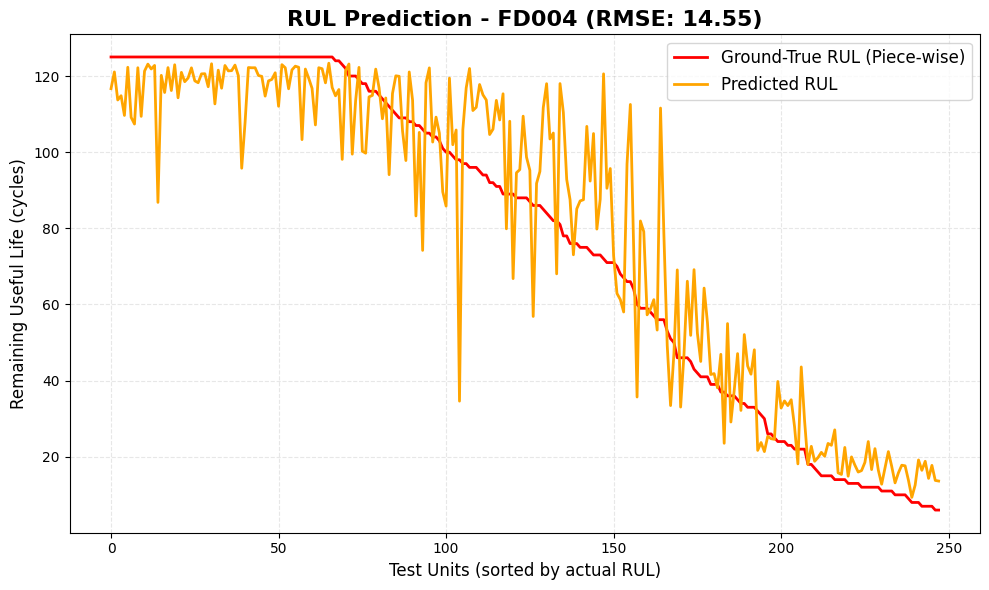


Results for FD004
RMSE: 14.54911
MAE:  10.78230


Sample Predictions:
 unit_id  predicted_RUL  actual_RUL
       1      43.592236          22
       2      41.609348          39
       3     105.195831         107
       4      87.190987          75
       5     116.682922         125
       6      92.835358          78
       7     113.695259          94
       8      15.776949          14
       9     101.959389          99
      10     122.297966         125


In [ ]:
# Load best model and evaluate
model.load_state_dict(torch.load(f'best_model_{config.dataset}.pth'))
final_rmse, final_results = evaluate(model, test_loader, config.device,
                                     config.rul_max, y_test)

# Visualize
visualize_results(final_results, final_rmse, config.dataset)

# Show samples
print("\nSample Predictions:")
print(final_results.head(10).to_string(index=False))

In [ ]:
# Initialize results storage
all_results = {}
datasets_to_train = ['FD001', 'FD002', 'FD003', 'FD004']

print(f"\n{'='*80}")
print(f"TRAINING PIPELINE FOR ALL 4 DATASETS")
print(f"{'='*80}")


TRAINING PIPELINE FOR ALL 4 DATASETS


In [ ]:
import time


################################################################################
# TRAINING FD001
################################################################################

Configuration:
  - Sensors: 14
  - Dropout: 0.1
  - Normalization: Min-Max
  - Clustering: No

Loading FD001 data...

Loading FD001 Dataset

Raw data loaded:
  Training: 20631 samples, 100 units
  Testing: 13096 samples, 100 units

Step 1: Single operating condition (no clustering needed)

Step 2: Feature selection...
  Dropping sensors: ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']
  Dropping operational settings: ['setting_1', 'setting_2', 'setting_3']
  Retained sensors: 14
  Sensor list: ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

Step 3: Normalization...
Applied Min-Max normalization (single operating condition)

Step 4: Adding piece-wise RUL (max=125)...

Data preprocessing completed for FD001

Creating datasets with sequence lengt

Epoch [  1/100] | Loss: 0.02850 | RMSE: 14.09408 | LR: 1.00e-03 ← Best!


Epoch [  2/100] | Loss: 0.01401 | RMSE: 16.73472 | LR: 1.00e-03


Epoch [  3/100] | Loss: 0.01253 | RMSE: 16.80616 | LR: 1.00e-03


Epoch [  4/100] | Loss: 0.01218 | RMSE: 15.96977 | LR: 1.00e-03


Epoch [  5/100] | Loss: 0.01201 | RMSE: 13.74579 | LR: 1.00e-03 ← Best!


Epoch [  6/100] | Loss: 0.01174 | RMSE: 13.36600 | LR: 1.00e-03 ← Best!


Epoch [  7/100] | Loss: 0.01134 | RMSE: 15.42053 | LR: 1.00e-03


Epoch [  8/100] | Loss: 0.01138 | RMSE: 13.19469 | LR: 1.00e-03 ← Best!


Epoch [  9/100] | Loss: 0.01118 | RMSE: 13.59618 | LR: 1.00e-03


Epoch [ 10/100] | Loss: 0.01121 | RMSE: 13.35024 | LR: 1.00e-03


Epoch [ 11/100] | Loss: 0.01110 | RMSE: 13.41431 | LR: 1.00e-03


Epoch [ 12/100] | Loss: 0.01111 | RMSE: 14.29230 | LR: 5.00e-04


Epoch [ 13/100] | Loss: 0.01036 | RMSE: 13.26221 | LR: 5.00e-04


Epoch [ 14/100] | Loss: 0.01021 | RMSE: 12.84347 | LR: 5.00e-04 ← Best!


Epoch [ 15/100] | Loss: 0.01022 | RMSE: 12.90655 | LR: 5.00e-04


Epoch [ 16/100] | Loss: 0.01025 | RMSE: 13.83734 | LR: 5.00e-04


Epoch [ 17/100] | Loss: 0.01005 | RMSE: 12.86163 | LR: 5.00e-04


Epoch [ 18/100] | Loss: 0.01018 | RMSE: 12.91009 | LR: 2.50e-04


Epoch [ 19/100] | Loss: 0.00990 | RMSE: 12.55986 | LR: 2.50e-04 ← Best!


Epoch [ 20/100] | Loss: 0.00985 | RMSE: 13.13684 | LR: 2.50e-04


Epoch [ 21/100] | Loss: 0.00973 | RMSE: 12.94511 | LR: 2.50e-04


Epoch [ 22/100] | Loss: 0.00953 | RMSE: 12.99331 | LR: 2.50e-04


Epoch [ 23/100] | Loss: 0.00949 | RMSE: 13.02069 | LR: 1.25e-04


Epoch [ 24/100] | Loss: 0.00931 | RMSE: 12.55408 | LR: 1.25e-04 ← Best!


Epoch [ 25/100] | Loss: 0.00924 | RMSE: 12.80727 | LR: 1.25e-04


Epoch [ 26/100] | Loss: 0.00925 | RMSE: 13.45404 | LR: 1.25e-04


Epoch [ 27/100] | Loss: 0.00920 | RMSE: 12.80716 | LR: 1.25e-04


Epoch [ 28/100] | Loss: 0.00919 | RMSE: 12.95497 | LR: 6.25e-05


Epoch [ 29/100] | Loss: 0.00901 | RMSE: 12.69496 | LR: 6.25e-05


Epoch [ 30/100] | Loss: 0.00904 | RMSE: 12.81923 | LR: 6.25e-05


Epoch [ 31/100] | Loss: 0.00893 | RMSE: 12.69245 | LR: 6.25e-05


Epoch [ 32/100] | Loss: 0.00900 | RMSE: 13.03937 | LR: 3.13e-05


Epoch [ 33/100] | Loss: 0.00883 | RMSE: 13.08680 | LR: 3.13e-05


Epoch [ 34/100] | Loss: 0.00882 | RMSE: 12.82844 | LR: 3.13e-05


Epoch [ 35/100] | Loss: 0.00888 | RMSE: 13.15728 | LR: 3.13e-05


Epoch [ 36/100] | Loss: 0.00875 | RMSE: 12.90537 | LR: 1.56e-05


Epoch [ 37/100] | Loss: 0.00886 | RMSE: 12.54763 | LR: 1.56e-05 ← Best!


Epoch [ 38/100] | Loss: 0.00873 | RMSE: 12.79847 | LR: 1.56e-05


Epoch [ 39/100] | Loss: 0.00875 | RMSE: 12.76533 | LR: 1.56e-05


Epoch [ 40/100] | Loss: 0.00869 | RMSE: 12.72416 | LR: 1.56e-05


Epoch [ 41/100] | Loss: 0.00870 | RMSE: 12.76474 | LR: 7.81e-06


Epoch [ 42/100] | Loss: 0.00872 | RMSE: 12.73751 | LR: 7.81e-06


Epoch [ 43/100] | Loss: 0.00868 | RMSE: 12.78122 | LR: 7.81e-06


Epoch [ 44/100] | Loss: 0.00874 | RMSE: 12.73276 | LR: 7.81e-06


Epoch [ 45/100] | Loss: 0.00870 | RMSE: 12.67055 | LR: 3.91e-06


Epoch [ 46/100] | Loss: 0.00866 | RMSE: 12.69184 | LR: 3.91e-06


Epoch [ 47/100] | Loss: 0.00866 | RMSE: 12.71167 | LR: 3.91e-06


Epoch [ 48/100] | Loss: 0.00871 | RMSE: 12.67647 | LR: 3.91e-06


Epoch [ 49/100] | Loss: 0.00866 | RMSE: 12.67357 | LR: 1.95e-06


Epoch [ 50/100] | Loss: 0.00871 | RMSE: 12.68545 | LR: 1.95e-06


Epoch [ 51/100] | Loss: 0.00867 | RMSE: 12.67005 | LR: 1.95e-06


Epoch [ 52/100] | Loss: 0.00867 | RMSE: 12.67764 | LR: 1.95e-06

Training stopped early at epoch 52
Best RMSE: 12.54763 at epoch 37

Training completed! Best RMSE: 12.54763



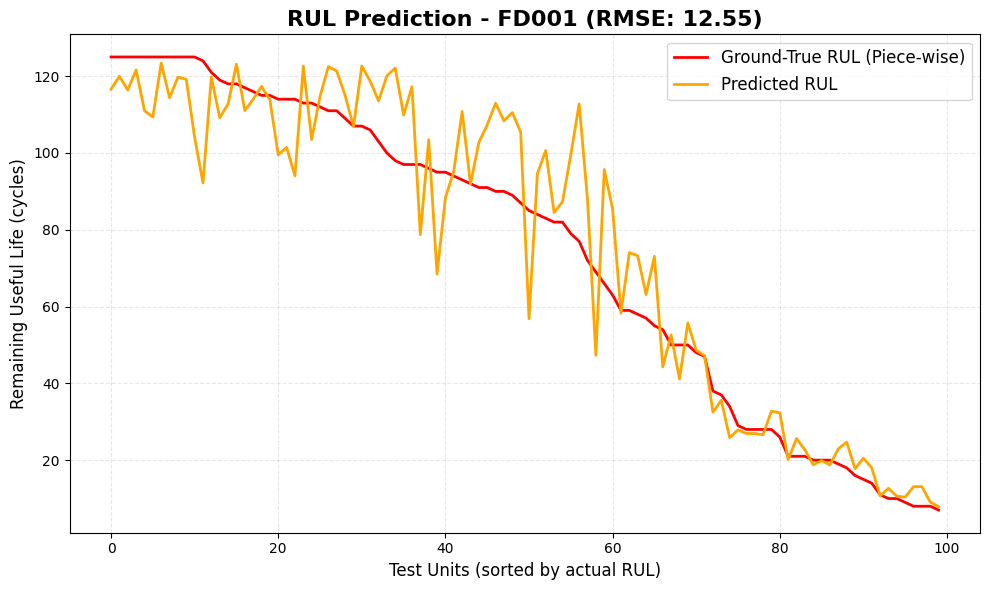


Results for FD001
RMSE: 12.54763
MAE:  9.36706



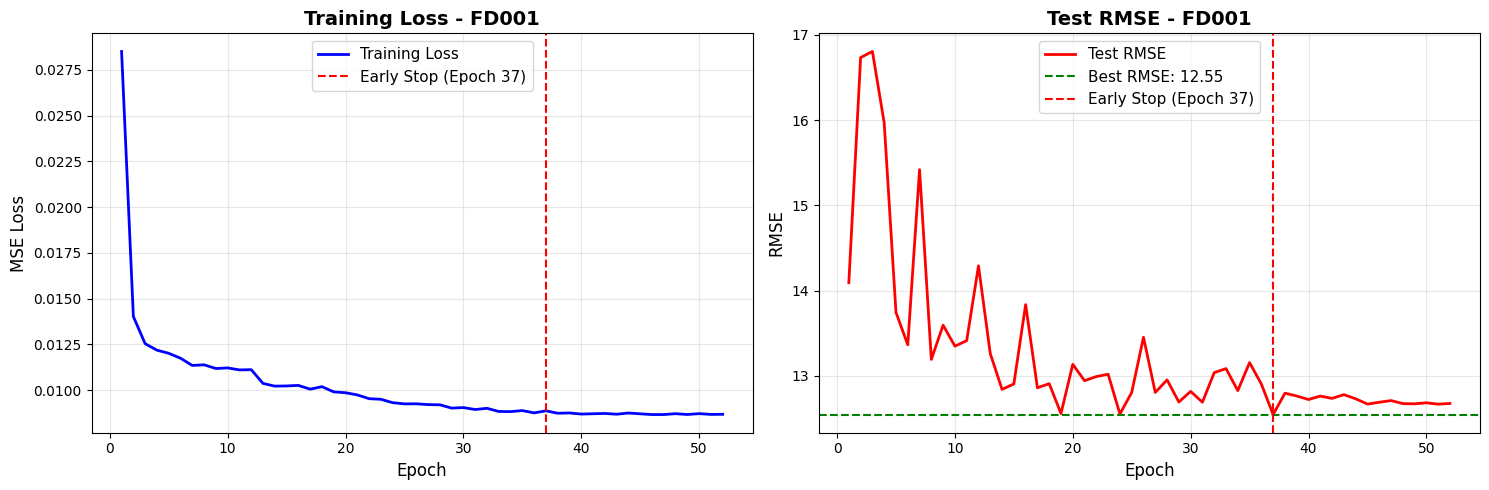


################################################################################
# TRAINING FD002
################################################################################

Configuration:
  - Sensors: 19
  - Dropout: 0.5
  - Normalization: Z-score/cluster
  - Clustering: Yes (K=6)

Loading FD002 data...

Loading FD002 Dataset

Raw data loaded:
  Training: 53759 samples, 260 units
  Testing: 33991 samples, 259 units

Step 1: Clustering operating conditions (K=6)...

Operating Condition Clusters:
Cluster | Setting_1 (Alt) | Setting_2 (Mach) | Setting_3 (TRA)
-----------------------------------------------------------------
  1    |     42.00     |       0.84      |    100.00
  2    |     20.00     |       0.70      |    100.00
  3    |     25.00     |       0.62      |     60.00
  4    |      0.00     |       0.00      |    100.00
  5    |     10.00     |       0.25      |    100.00
  6    |     35.00     |       0.84      |    100.00

Step 2: Feature selection...
  Dropping sens

Epoch [  1/100] | Loss: 0.02116 | RMSE: 19.54936 | LR: 1.00e-03 ← Best!


Epoch [  2/100] | Loss: 0.01407 | RMSE: 17.92971 | LR: 1.00e-03 ← Best!


Epoch [  3/100] | Loss: 0.01172 | RMSE: 16.47533 | LR: 1.00e-03 ← Best!


Epoch [  4/100] | Loss: 0.00980 | RMSE: 18.27354 | LR: 1.00e-03


Epoch [  5/100] | Loss: 0.00837 | RMSE: 18.62650 | LR: 1.00e-03


Epoch [  6/100] | Loss: 0.00745 | RMSE: 19.21706 | LR: 1.00e-03


Epoch [  7/100] | Loss: 0.00669 | RMSE: 18.80795 | LR: 5.00e-04


Epoch [  8/100] | Loss: 0.00536 | RMSE: 17.80334 | LR: 5.00e-04


Epoch [  9/100] | Loss: 0.00504 | RMSE: 18.18355 | LR: 5.00e-04


Epoch [ 10/100] | Loss: 0.00475 | RMSE: 18.86961 | LR: 5.00e-04


Epoch [ 11/100] | Loss: 0.00451 | RMSE: 18.24190 | LR: 2.50e-04


Epoch [ 12/100] | Loss: 0.00404 | RMSE: 18.39013 | LR: 2.50e-04


Epoch [ 13/100] | Loss: 0.00387 | RMSE: 18.46434 | LR: 2.50e-04


Epoch [ 14/100] | Loss: 0.00380 | RMSE: 18.06268 | LR: 2.50e-04


Epoch [ 15/100] | Loss: 0.00374 | RMSE: 17.94861 | LR: 1.25e-04


Epoch [ 16/100] | Loss: 0.00349 | RMSE: 18.19412 | LR: 1.25e-04


Epoch [ 17/100] | Loss: 0.00342 | RMSE: 18.40405 | LR: 1.25e-04


Epoch [ 18/100] | Loss: 0.00337 | RMSE: 18.46042 | LR: 1.25e-04

Training stopped early at epoch 18
Best RMSE: 16.47533 at epoch 3

Training completed! Best RMSE: 16.47533



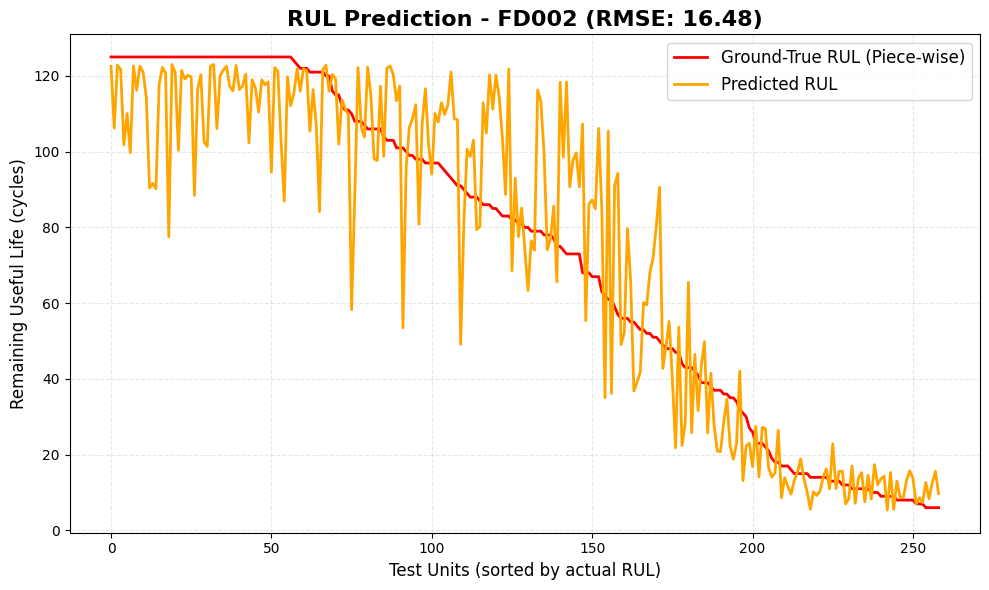


Results for FD002
RMSE: 16.47533
MAE:  12.12024



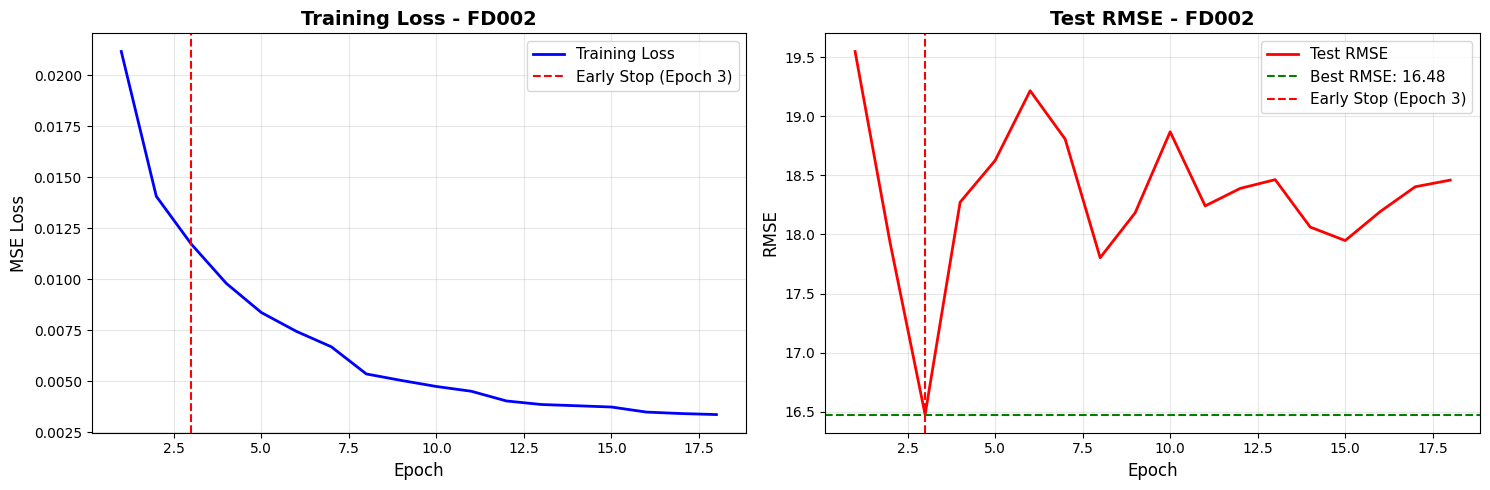


################################################################################
# TRAINING FD003
################################################################################

Configuration:
  - Sensors: 14
  - Dropout: 0.1
  - Normalization: Min-Max
  - Clustering: No

Loading FD003 data...

Loading FD003 Dataset

Raw data loaded:
  Training: 24720 samples, 100 units
  Testing: 16596 samples, 100 units

Step 1: Single operating condition (no clustering needed)

Step 2: Feature selection...
  Dropping sensors: ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']
  Dropping operational settings: ['setting_1', 'setting_2', 'setting_3']
  Retained sensors: 14
  Sensor list: ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

Step 3: Normalization...
Applied Min-Max normalization (single operating condition)

Step 4: Adding piece-wise RUL (max=125)...

Data preprocessing completed for FD003

Creating datasets with sequence lengt

Epoch [  1/100] | Loss: 0.03403 | RMSE: 16.56545 | LR: 1.00e-03 ← Best!


Epoch [  2/100] | Loss: 0.01405 | RMSE: 16.11144 | LR: 1.00e-03 ← Best!


Epoch [  3/100] | Loss: 0.01186 | RMSE: 14.84313 | LR: 1.00e-03 ← Best!


Epoch [  4/100] | Loss: 0.01103 | RMSE: 14.74128 | LR: 1.00e-03 ← Best!


Epoch [  5/100] | Loss: 0.00997 | RMSE: 14.29175 | LR: 1.00e-03 ← Best!


Epoch [  6/100] | Loss: 0.00972 | RMSE: 13.78937 | LR: 1.00e-03 ← Best!


Epoch [  7/100] | Loss: 0.00933 | RMSE: 14.57327 | LR: 1.00e-03


Epoch [  8/100] | Loss: 0.00915 | RMSE: 13.94320 | LR: 1.00e-03


Epoch [  9/100] | Loss: 0.00905 | RMSE: 13.00974 | LR: 1.00e-03 ← Best!


Epoch [ 10/100] | Loss: 0.00875 | RMSE: 16.18525 | LR: 1.00e-03


Epoch [ 11/100] | Loss: 0.00904 | RMSE: 14.14753 | LR: 1.00e-03


Epoch [ 12/100] | Loss: 0.00874 | RMSE: 13.75390 | LR: 1.00e-03


Epoch [ 13/100] | Loss: 0.00876 | RMSE: 12.19646 | LR: 1.00e-03 ← Best!


Epoch [ 14/100] | Loss: 0.00855 | RMSE: 12.89444 | LR: 1.00e-03


Epoch [ 15/100] | Loss: 0.00851 | RMSE: 12.37289 | LR: 1.00e-03


Epoch [ 16/100] | Loss: 0.00850 | RMSE: 12.40039 | LR: 1.00e-03


Epoch [ 17/100] | Loss: 0.00846 | RMSE: 12.70401 | LR: 5.00e-04


Epoch [ 18/100] | Loss: 0.00800 | RMSE: 12.05480 | LR: 5.00e-04 ← Best!


Epoch [ 19/100] | Loss: 0.00797 | RMSE: 12.85290 | LR: 5.00e-04


Epoch [ 20/100] | Loss: 0.00798 | RMSE: 12.68996 | LR: 5.00e-04


Epoch [ 21/100] | Loss: 0.00801 | RMSE: 12.57116 | LR: 5.00e-04


Epoch [ 22/100] | Loss: 0.00788 | RMSE: 12.80138 | LR: 2.50e-04


Epoch [ 23/100] | Loss: 0.00766 | RMSE: 12.61616 | LR: 2.50e-04


Epoch [ 24/100] | Loss: 0.00759 | RMSE: 11.94883 | LR: 2.50e-04 ← Best!


Epoch [ 25/100] | Loss: 0.00765 | RMSE: 12.77911 | LR: 2.50e-04


Epoch [ 26/100] | Loss: 0.00757 | RMSE: 12.49107 | LR: 2.50e-04


Epoch [ 27/100] | Loss: 0.00755 | RMSE: 12.28621 | LR: 2.50e-04


Epoch [ 28/100] | Loss: 0.00759 | RMSE: 12.19038 | LR: 1.25e-04


Epoch [ 29/100] | Loss: 0.00741 | RMSE: 12.18333 | LR: 1.25e-04


Epoch [ 30/100] | Loss: 0.00744 | RMSE: 11.96698 | LR: 1.25e-04


Epoch [ 31/100] | Loss: 0.00743 | RMSE: 11.96061 | LR: 1.25e-04


Epoch [ 32/100] | Loss: 0.00744 | RMSE: 11.64798 | LR: 1.25e-04 ← Best!


Epoch [ 33/100] | Loss: 0.00747 | RMSE: 12.19717 | LR: 1.25e-04


Epoch [ 34/100] | Loss: 0.00743 | RMSE: 12.22847 | LR: 1.25e-04


Epoch [ 35/100] | Loss: 0.00741 | RMSE: 11.83319 | LR: 1.25e-04


Epoch [ 36/100] | Loss: 0.00741 | RMSE: 12.67533 | LR: 6.25e-05


Epoch [ 37/100] | Loss: 0.00733 | RMSE: 11.71344 | LR: 6.25e-05


Epoch [ 38/100] | Loss: 0.00733 | RMSE: 11.84479 | LR: 6.25e-05


Epoch [ 39/100] | Loss: 0.00729 | RMSE: 12.71903 | LR: 6.25e-05


Epoch [ 40/100] | Loss: 0.00730 | RMSE: 11.93571 | LR: 3.13e-05


Epoch [ 41/100] | Loss: 0.00726 | RMSE: 11.76961 | LR: 3.13e-05


Epoch [ 42/100] | Loss: 0.00727 | RMSE: 11.76680 | LR: 3.13e-05


Epoch [ 43/100] | Loss: 0.00724 | RMSE: 11.97099 | LR: 3.13e-05


Epoch [ 44/100] | Loss: 0.00725 | RMSE: 11.94255 | LR: 1.56e-05


Epoch [ 45/100] | Loss: 0.00723 | RMSE: 11.98549 | LR: 1.56e-05


Epoch [ 46/100] | Loss: 0.00723 | RMSE: 11.92793 | LR: 1.56e-05


Epoch [ 47/100] | Loss: 0.00720 | RMSE: 11.93699 | LR: 1.56e-05

Training stopped early at epoch 47
Best RMSE: 11.64798 at epoch 32

Training completed! Best RMSE: 11.64798



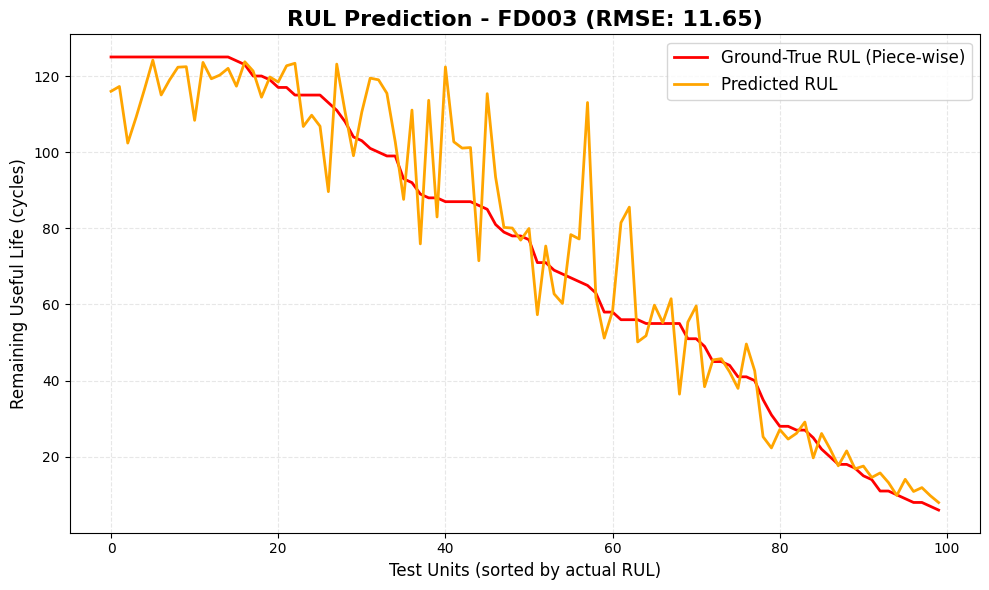


Results for FD003
RMSE: 11.64798
MAE:  8.03902



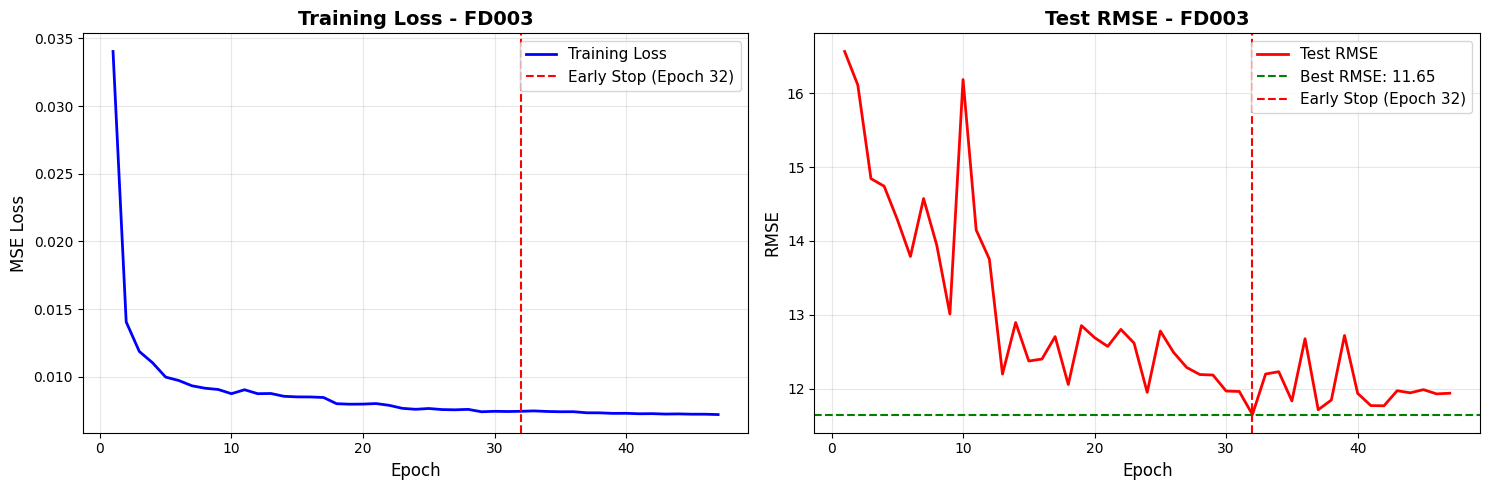


################################################################################
# TRAINING FD004
################################################################################

Configuration:
  - Sensors: 19
  - Dropout: 0.5
  - Normalization: Z-score/cluster
  - Clustering: Yes (K=6)

Loading FD004 data...

Loading FD004 Dataset

Raw data loaded:
  Training: 61249 samples, 249 units
  Testing: 41214 samples, 248 units

Step 1: Clustering operating conditions (K=6)...

Operating Condition Clusters:
Cluster | Setting_1 (Alt) | Setting_2 (Mach) | Setting_3 (TRA)
-----------------------------------------------------------------
  1    |     42.00     |       0.84      |    100.00
  2    |     20.00     |       0.70      |    100.00
  3    |     25.00     |       0.62      |     60.00
  4    |      0.00     |       0.00      |    100.00
  5    |     10.00     |       0.25      |    100.00
  6    |     35.00     |       0.84      |    100.00

Step 2: Feature selection...
  Dropping sens

Epoch [  1/100] | Loss: 0.01878 | RMSE: 16.24382 | LR: 1.00e-03 ← Best!


Epoch [  2/100] | Loss: 0.01415 | RMSE: 16.13775 | LR: 1.00e-03 ← Best!


Epoch [  3/100] | Loss: 0.01313 | RMSE: 15.85244 | LR: 1.00e-03 ← Best!


Epoch [  4/100] | Loss: 0.01242 | RMSE: 15.25012 | LR: 1.00e-03 ← Best!


Epoch [  5/100] | Loss: 0.01173 | RMSE: 15.48205 | LR: 1.00e-03


Epoch [  6/100] | Loss: 0.01098 | RMSE: 17.45063 | LR: 1.00e-03


Epoch [  7/100] | Loss: 0.01031 | RMSE: 15.92057 | LR: 1.00e-03


Epoch [  8/100] | Loss: 0.00958 | RMSE: 17.34608 | LR: 5.00e-04


Epoch [  9/100] | Loss: 0.00835 | RMSE: 17.46317 | LR: 5.00e-04


Epoch [ 10/100] | Loss: 0.00789 | RMSE: 16.53812 | LR: 5.00e-04


Epoch [ 11/100] | Loss: 0.00742 | RMSE: 17.61364 | LR: 5.00e-04


Epoch [ 12/100] | Loss: 0.00697 | RMSE: 17.85423 | LR: 2.50e-04


Epoch [ 13/100] | Loss: 0.00625 | RMSE: 17.39960 | LR: 2.50e-04


Epoch [ 14/100] | Loss: 0.00597 | RMSE: 17.61341 | LR: 2.50e-04


Epoch [ 15/100] | Loss: 0.00576 | RMSE: 18.41986 | LR: 2.50e-04


Epoch [ 16/100] | Loss: 0.00559 | RMSE: 17.42916 | LR: 1.25e-04


Epoch [ 17/100] | Loss: 0.00526 | RMSE: 17.53132 | LR: 1.25e-04


Epoch [ 18/100] | Loss: 0.00512 | RMSE: 17.84894 | LR: 1.25e-04


Epoch [ 19/100] | Loss: 0.00506 | RMSE: 17.87389 | LR: 1.25e-04

Training stopped early at epoch 19
Best RMSE: 15.25012 at epoch 4

Training completed! Best RMSE: 15.25012



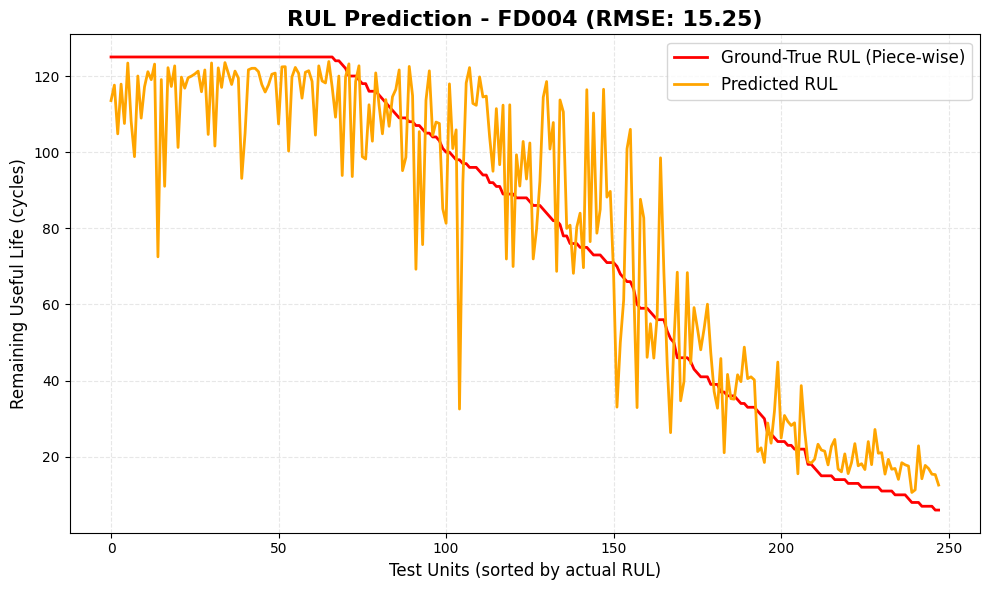


Results for FD004
RMSE: 15.25012
MAE:  11.26309



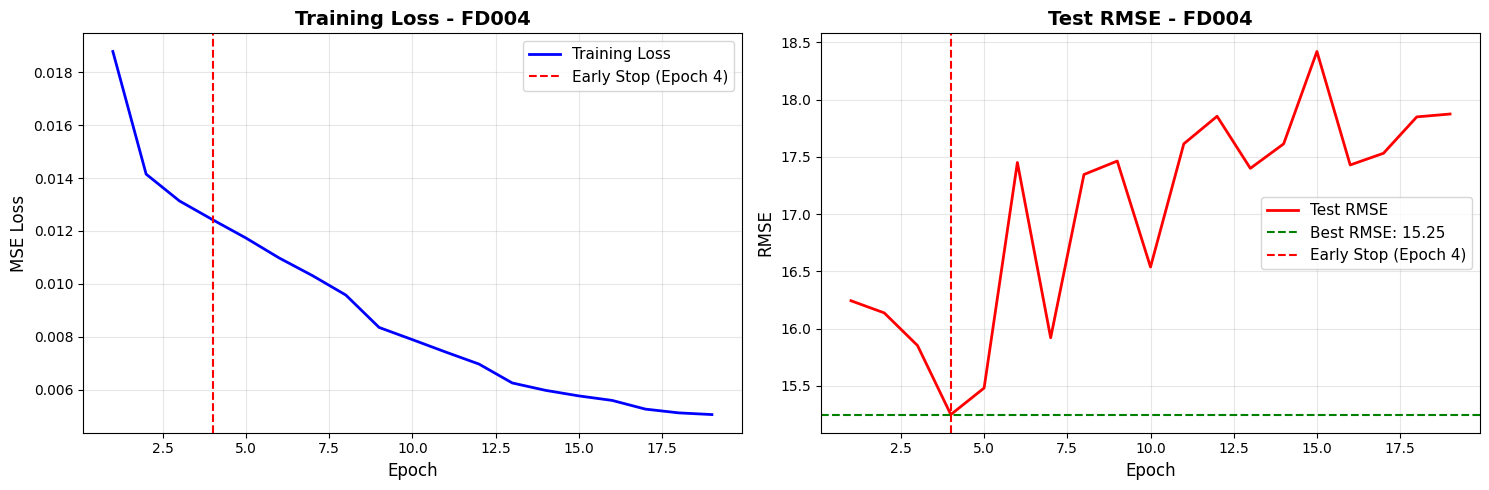

In [ ]:
final_results_dict = {}
for dataset_name in datasets_to_train:
  print(f"\n{'#'*80}")
  print(f"# TRAINING {dataset_name}")
  print(f"{'#'*80}\n")

  start_time = time.time()
  config.dataset = dataset_name

  print(f"Configuration:")
  print(f"  - Sensors: {config.num_features}")
  print(f"  - Dropout: {config.dropout}")
  print(f"  - Normalization: {'Z-score/cluster' if config.is_complex else 'Min-Max'}")
  print(f"  - Clustering: {'Yes (K=6)' if config.is_complex else 'No'}\n")

  ## Load data
  print(f"Loading {dataset_name} data...")
  train_df, test_df, y_test, kmeans = load_cmapss_data(
    dataset_name, config.data_dir, config
  )

  # Create datasets
  print(f"Creating datasets with sequence length = {config.sequence_length}...")
  train_dataset = CMAPSSDataset(train_df, config.sequence_length, is_train=True, stride=1)
  test_dataset = CMAPSSDataset(test_df, config.sequence_length, is_train=False)

  print(f"Training samples: {len(train_dataset)}")
  print(f"Testing samples: {len(test_dataset)}")

  # Dataloaders
  train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        num_workers=0)
  test_loader = DataLoader(test_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        num_workers=0)

  # Initialize model
  print(f"Initializing model...")
  model = Transformer(
    num_features=config.num_features,
    d_model=config.d_model,
    n_layers=config.n_layers,
    n_heads=config.n_heads,
    dropout=config.dropout
  ).to(config.device)

  # Xavier initialization
  for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

  optimizer = torch.optim.Adam(model.parameters(),
                            lr=config.learning_rate,
                            weight_decay=1e-4)
  criterion = nn.MSELoss()

  total_params = sum(p.numel() for p in model.parameters())
  print(f"\nModel initialized with {total_params:,} parameters")
  print(f"Device: {config.device}\n")


  # Training loop WITH EARLY STOPPING
  print(f"\nTraining {config.dataset} for up to {config.num_epochs} epochs...")
  print(f"Early stopping patience: {config.early_stop_patience}\n")

  best_rmse = float('inf')
  best_model_state = None
  train_losses = []
  test_rmses = []

  # Khởi tạo Early Stopping
  early_stopping = EarlyStopping(
    patience=config.early_stop_patience,
    min_delta=config.early_stop_min_delta,
  )

  # Learning Rate Scheduler
  scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=config.lr_factor,
    patience=config.lr_patience,
    min_lr=config.min_lr,
  )

  for epoch in range(config.num_epochs):
    # Training
    train_loss = train_epoch(model, train_loader, optimizer, criterion,
                            config.device, config.rul_max)
    train_losses.append(train_loss)

    # Evaluation
    test_rmse, test_results = evaluate(model, test_loader, config.device,
                                    config.rul_max, y_test)
    test_rmses.append(test_rmse)

    # Update learning rate
    scheduler.step(test_rmse)
    current_lr = optimizer.param_groups[0]['lr']

    # Print progress
    print(f"Epoch [{epoch+1:3d}/{config.num_epochs}] | "
        f"Loss: {train_loss:.5f} | "
        f"RMSE: {test_rmse:.5f} | "
        f"LR: {current_lr:.2e}", end='')

    # Save best model
    if test_rmse < best_rmse:
        best_rmse = test_rmse
        best_model_state = model.state_dict().copy()
        torch.save(best_model_state, f'best_model_{config.dataset}.pth')
        print(f" ← Best!", end='')

    print()  # New line

    # Early stopping check
    if early_stopping(test_rmse, epoch):
        print(f"\n{'='*70}")
        print(f"Training stopped early at epoch {epoch + 1}")
        print(f"Best RMSE: {best_rmse:.5f} at epoch {early_stopping.best_epoch + 1}")
        print(f"{'='*70}\n")
        break
  else:
    # Chạy hết epochs mà không dừng sớm
    print(f"\n{'='*70}")
    print(f"Training completed all {config.num_epochs} epochs")
    print(f"Best RMSE: {best_rmse:.5f}")
    print(f"{'='*70}\n")


  # Load best model and evaluate
  if best_model_state is not None:
    model.load_state_dict(torch.load(f'best_model_{config.dataset}.pth'))
    print(f"Training completed! Best RMSE: {best_rmse:.5f}\n")
    final_rmse, final_results = evaluate(model, test_loader, config.device,
                                    config.rul_max, y_test)

    # Visualize
    visualize_results(final_results, final_rmse, config.dataset)
    final_results_dict[dataset_name] = final_rmse



  # Vẽ training history
  early_stop_epoch = early_stopping.best_epoch + 1 if early_stopping.early_stop else None
  plot_training_history(train_losses, test_rmses, config.dataset, best_rmse, early_stop_epoch)


In [ ]:
print(f"\n{'='*80}")
print("TỔNG HỢP KẾT QUẢ TRÊN TẤT CẢ DỮ LIỆU")
print(f"{'='*80}")

if len(final_results_dict) > 0:
    # Tạo DataFrame từ dictionary
    summary_df = pd.DataFrame(list(final_results_dict.items()), columns=['Dataset', 'RMSE'])

    # Sắp xếp theo tên dataset cho dễ nhìn
    summary_df = summary_df.sort_values('Dataset')

    # Tính trung bình cộng cột RMSE
    average_rmse = summary_df['RMSE'].mean()

    # In bảng kết quả
    print(summary_df)
    print(f"{'-'*30}")
    print(f"AVERAGE RMSE ({len(final_results_dict)} Datasets): {average_rmse:.4f}")

print(f"{'='*80}\n")


TỔNG HỢP KẾT QUẢ TRÊN TẤT CẢ DỮ LIỆU
  Dataset       RMSE
0   FD001  12.547627
1   FD002  16.475334
2   FD003  11.647975
3   FD004  15.250121
------------------------------
AVERAGE RMSE (4 Datasets): 13.9803



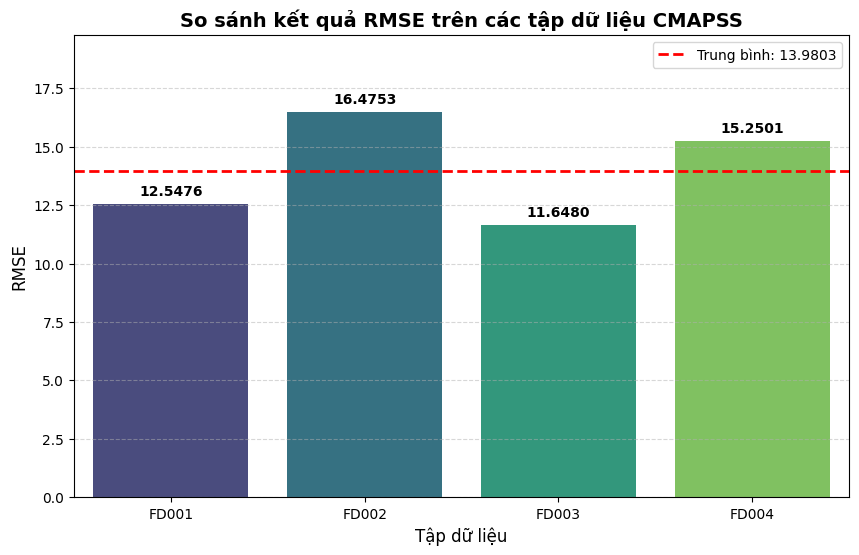

In [ ]:
if len(final_results_dict) > 0:
    plt.figure(figsize=(10, 6))

    # Vẽ biểu đồ cột
    ax = sns.barplot(x='Dataset', y='RMSE', data=summary_df, palette='viridis')

    # --- Thêm số liệu cụ thể lên đầu mỗi cột ---
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points',
                   fontweight='bold')

    # --- Vẽ đường trung bình (Average Line) ---
    plt.axhline(y=average_rmse, color='red', linestyle='--', linewidth=2, label=f'Trung bình: {average_rmse:.4f}')

    # Trang trí biểu đồ
    plt.title('So sánh kết quả RMSE trên các tập dữ liệu CMAPSS', fontsize=14, fontweight='bold')
    plt.ylabel('RMSE', fontsize=12)
    plt.xlabel('Tập dữ liệu', fontsize=12)
    plt.ylim(0, summary_df['RMSE'].max() * 1.2) # Tăng chiều cao trục Y để số không bị che
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Lưu biểu đồ thành file ảnh
    plt.savefig('Final_RMSE_Comparison.png', dpi=300, bbox_inches='tight')

    # Hiển thị
    plt.show()

Ta thấy rằng mô hình hoạt động tốt với cả 4 bộ dữ liệu bao gồm các tập dữ liệu đơn điều kiện (FD001 và FD003) và cả các tập dữ liệu đa điều kiện (FD002 và FD004).

Tuy nhiên, để đánh giá kết quả RMSE thu được là tốt hay chưa ta sẽ thực hiện so sánh với hai loại mô hình khác là CNN và LTSM (Long-Short Term Memory).

Kết quả cho ra như sau

| Method          | FD001  | FD002  | FD003  | FD004  | Average |
|-----------------|--------|--------|--------|--------|---------|
| CNN             | 16.309 | 14.881 | 31.585 | 32.646 | 23.855  |
| LTSM            | 15.109 | 25.820 | 15.141 | 29.435 | 21.127  |
| GCU-Transformer | 12.547 | 16.475 | 11.647 | 15.250 | 13.980  |
**Bảng 1: Chỉ số RMSE giữa mô hình chính và các mô hình khác**

Có thể thấy được mô hình chúng ta chọn cho ra kết quả tốt hơn so với các mô hình CNN hoặc LSTM thường được sử dụng.


# 8. Nghiên cứu loại bỏ
Để kiểm tra xem với các thiết đặt cho mô hình có ảnh hưởng tới kết quả không chúng ta sẽ thực hiện **Nghiên cứu loại bỏ**. Cụ thể chúng ta sẽ huấn luyện lại với các biến thể của mô hình ban đầu. Chúng ta sẽ thử nghiệm các biến thể này trên bộ dữ liệu FD002.

## 8.1. Loại bỏ GCU
Biến thể này bỏ đi khối tích chập có cổng (GCU) được dùng để xử lý các phép tích chập và cơ chế cổng.

In [ ]:
class Transformer_NoGCU(nn.Module):
  '''
  Biến thể bỏ GCU
  '''
  def __init__(self, num_features, d_model, n_layers, n_heads, dropout):
      super().__init__()
      # Thay GCU bằng Linear Projection thông thường
      self.input_proj = nn.Linear(num_features, d_model)
      # Giữ nguyên Transformer Encoder
      self.encoder = Encoder(d_model, n_layers, n_heads, dropout)
      self.out = nn.Linear(d_model, 1)

  def forward(self, src, mask=None):
      x = self.input_proj(src)        # -> [batch, seq_len, d_model]
      x = self.encoder(x, mask)       # -> [batch, seq_len, d_model]
      x = x[:, -1, :]                 # -> [batch, d_model]
      out = self.out(x)
      return torch.sigmoid(out)

## 8.2. Loại bỏ GCU + Sigmoid
Biến thể này loại bỏ cả GCU và hàm Sigmoid, khi đó mô hình của chúng ta trở thành một bộ mã hóa Transformer thuần túy với một ánh xạ tuyến tính từ các đặc trưng ẩn sang giá trị RUL đầu ra.

In [ ]:
class Transformer_NoGCU_LinearOut(nn.Module):
    """
    Biến thể:
    1. Bỏ GCU -> Thay bằng Linear Projection (input_proj).
    2. Bỏ Sigmoid -> Đầu ra tuyến tính (Linear Output).
    3. Giữ Transformer Encoder.
    """
    def __init__(self, num_features, d_model, n_layers, n_heads, dropout):
        super().__init__()
        # Thay thế GCU bằng một lớp Linear đơn giản để chiếu chiều dữ liệu
        self.input_proj = nn.Linear(num_features, d_model)

        # Vẫn giữ Transformer Encoder để học quan hệ chuỗi thời gian
        self.encoder = Encoder(d_model, n_layers, n_heads, dropout)

        # Lớp đầu ra cuối cùng
        self.out = nn.Linear(d_model, 1)

    def forward(self, src, mask=None):
        x = self.input_proj(src)       # [Batch, Seq, Feature] -> [Batch, Seq, d_model]
        x = self.encoder(x, mask)      # Qua Transformer Encoder
        x = x[:, -1, :]                # Lấy bước thời gian cuối cùng
        out = self.out(x)              # Qua Linear Output
        return out                     # Trả về trực tiếp (Không có Sigmoid)

In [ ]:
# Cấu hình lại
config.dataset = 'FD002'
config.num_epochs = 100
print(f"Dataset: {config.dataset} | Epochs: {config.num_epochs}")

# Load lại dữ liệu FD002
print(f"Loading {config.dataset} data for ablation...")
train_df, test_df, y_test, kmeans = load_cmapss_data(config.dataset, config.data_dir, config)


Dataset: FD002 | Epochs: 100
Loading FD002 data for ablation...

Loading FD002 Dataset

Raw data loaded:
  Training: 53759 samples, 260 units
  Testing: 33991 samples, 259 units

Step 1: Clustering operating conditions (K=6)...

Operating Condition Clusters:
Cluster | Setting_1 (Alt) | Setting_2 (Mach) | Setting_3 (TRA)
-----------------------------------------------------------------
  1    |     42.00     |       0.84      |    100.00
  2    |     20.00     |       0.70      |    100.00
  3    |     25.00     |       0.62      |     60.00
  4    |      0.00     |       0.00      |    100.00
  5    |     10.00     |       0.25      |    100.00
  6    |     35.00     |       0.84      |    100.00

Step 2: Feature selection...
  Dropping sensors: ['s_1', 's_18']
  Dropping operational settings: ['setting_1', 'setting_2', 'setting_3']
  Retained sensors: 19
  Sensor list: ['s_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_1

In [ ]:
# Tạo Dataloader
train_dataset = CMAPSSDataset(train_df, config.sequence_length, is_train=True, stride=1)
test_dataset = CMAPSSDataset(test_df, config.sequence_length, is_train=False)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)

In [ ]:
# DANH SÁCH MÔ HÌNH
ablation_results = {}
# Lấy dữ liệu GCU + Transformer
if 'FD002' in final_results_dict:
    print(f"\n Đã tìm thấy kết quả Proposed (FD002) từ phần training trước.")
    ablation_results["Proposed"] = final_results_dict['FD002']
    print(f"Proposed RMSE: {ablation_results['Proposed']:.4f}")
else:
    print("\n Không tìm thấy kết quả FD002 ở phần trên. Sẽ huấn luyện lại Proposed model.")
    # Nếu chưa có thì thêm vào danh sách để train
    variants["Proposed"] = Transformer(config.num_features, config.d_model, config.n_layers, config.n_heads, config.dropout)

# Huấn luyện các biến thể chưa có
variants_to_train = {
    "w/o GCU": Transformer_NoGCU(config.num_features, config.d_model, config.n_layers, config.n_heads, config.dropout),
    "w/o GCU + Sigmoid": Transformer_NoGCU_LinearOut(config.num_features, config.d_model, config.n_layers, config.n_heads, config.dropout)
}


 Đã tìm thấy kết quả Proposed (FD002) từ phần training trước.
Proposed RMSE: 16.4753


In [ ]:
# HUẤN LUYỆN BIẾN THỂ
for name, model in variants_to_train.items():
    print(f"\n{'-'*60}")
    print(f"HUẤN LUYỆN BIẾN THỂ: {name.upper()}")
    print(f"{'-'*60}")

    model = model.to(config.device)
    # Khởi tạo lại optimizer cho mỗi model
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.MSELoss()

    # Early Stopping riêng cho Ablation
    early_stopping_ablation = EarlyStopping(patience=config.early_stop_patience, min_delta=0.001)

    best_rmse_variant = float('inf')

    for epoch in range(config.num_epochs):
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, config.device, config.rul_max)

        # Evaluate
        rmse, _ = evaluate(model, test_loader, config.device, config.rul_max, y_test)

        if epoch % 10 == 0 or epoch == config.num_epochs - 1:
             print(f"Epoch {epoch+1:03d}/{config.num_epochs} | Train Loss: {train_loss:.6f} | Test RMSE: {rmse:.4f}")

        # Check Early Stopping & Save Best
        if rmse < best_rmse_variant:
            best_rmse_variant = rmse

        if early_stopping_ablation(rmse, epoch):
            print(f" >> Early stopping tại epoch {epoch+1}. Best RMSE: {best_rmse_variant:.4f}")
            break

    ablation_results[name] = best_rmse_variant
    print(f"--> Kết thúc {name}. RMSE tối ưu: {best_rmse_variant:.4f}")



------------------------------------------------------------
HUẤN LUYỆN BIẾN THỂ: W/O GCU
------------------------------------------------------------


Epoch 001/100 | Train Loss: 0.020811 | Test RMSE: 17.2326


Epoch 011/100 | Train Loss: 0.006127 | Test RMSE: 18.1953


 >> Early stopping tại epoch 16. Best RMSE: 17.2326
--> Kết thúc w/o GCU. RMSE tối ưu: 17.2326

------------------------------------------------------------
HUẤN LUYỆN BIẾN THỂ: W/O GCU + SIGMOID
------------------------------------------------------------


Epoch 001/100 | Train Loss: 0.028242 | Test RMSE: 17.5293


Epoch 011/100 | Train Loss: 0.007382 | Test RMSE: 18.6859


 >> Early stopping tại epoch 19. Best RMSE: 17.3699
--> Kết thúc w/o GCU + Sigmoid. RMSE tối ưu: 17.3699



==================== KẾT QUẢ ABLATION STUDY (FD002) ====================
       Model Variant       RMSE
0           Proposed  16.475334
1            w/o GCU  17.232645
2  w/o GCU + Sigmoid  17.369861


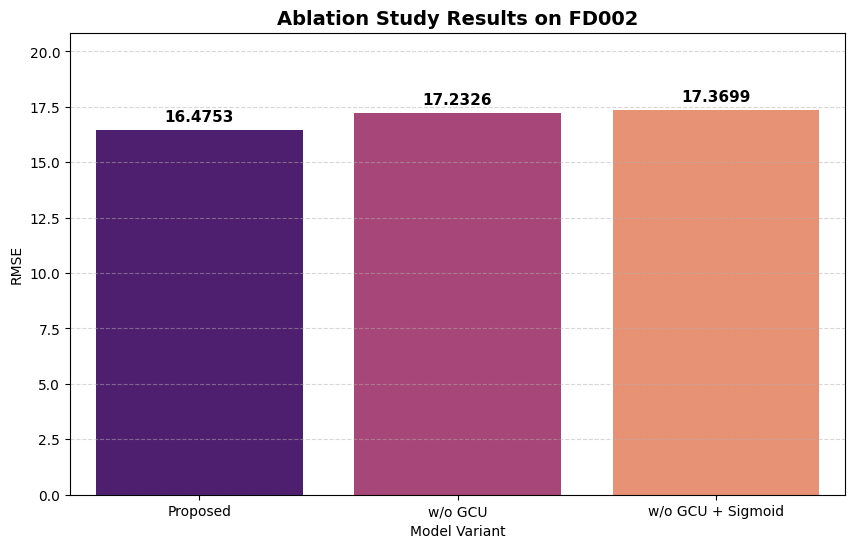

In [ ]:
print(f"\n{'='*20} KẾT QUẢ ABLATION STUDY (FD002) {'='*20}")
df_ablation = pd.DataFrame(list(ablation_results.items()), columns=['Model Variant', 'RMSE'])
df_ablation = df_ablation.sort_values('RMSE')

print(df_ablation)

plt.figure(figsize=(10, 6))
# Vẽ biểu đồ cột
ax = sns.barplot(x='Model Variant', y='RMSE', data=df_ablation, palette='magma')

# Thêm số liệu lên đầu cột
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}',
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha = 'center', va = 'center',
               xytext = (0, 9),
               textcoords = 'offset points',
               fontweight='bold', fontsize=11)

plt.title('Ablation Study Results on FD002', fontsize=14, fontweight='bold')
plt.ylabel('RMSE')
plt.ylim(0, df_ablation['RMSE'].max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Có thể nhận thấy cả hai biến thể của mô hình chính đều dẫn tới sự suy yếu của mô hình.
| Mô hình | RMSE | $\Delta$ |
|---|---|---|
| Mô hình chính | 16.475 | - |
| Biến thể loại bỏ GCU | 17.232 | -0.757 |
| Biến thể loại bỏ GCU và Sigmoid | 17.369 | -0.894 |
**Bảng 2: Chỉ số RMSE các mô hình trong nghiên cứu loại bỏ**




# 9. Kết luận và Phương hướng phát triển

## 9.1. Kết quả tổng thể

Để đánh giá hiệu quả của mô hình đề xuất (GCU-Transformer), dự án thực hiện so sánh với hai mô hình học sâu phổ biến là CNN và LSTM trên cả 4 tập dữ liệu con (FD001 - FD004).  

**Bảng 1: So sánh RMSE giữa các mô hình trên bộ dữ liệu C-MAPSS**
| Method          | FD001  | FD002  | FD003  | FD004  | Average |
|-----------------|--------|--------|--------|--------|---------|
| CNN             | 16.309 | 14.881 | 31.585 | 32.646 | 23.855  |
| LTSM            | 15.109 | 25.820 | 15.141 | 29.435 | 21.127  |
| GCU-Transformer | 12.547 | 16.475 | 11.647 | 15.250 | 13.980  |


Nhận xét:
- Vượt trội về độ chính xác.
- Duy trì độ ổn định cao cho thấy khả năng thích ứng với điều kiện phức tạp.
- Hiệu quả trên cả dữ liệu đơn giản --> Khẳng định tính toàn diện của giải pháp.

<br>

Để kiểm chứng vai trò của từng thành phần cốt lõi trong kiến trúc, dự án tiến hành thử nghiệm trên tập dữ liệu phức tạp FD002 bằng cách loại bỏ lần lượt các module.

**Bảng 2: Chỉ số RMSE các mô hình trong nghiên cứu loại bỏ**

| Mô hình | RMSE | $\Delta$ |
|---|---|---|
| Mô hình chính | 16.475 | - |
| Biến thể loại bỏ GCU | 17.232 | -0.757 |
| Biến thể loại bỏ GCU và Sigmoid | 17.369 | -0.894 |




Bài báo này đề xuất một mô hình kiến trúc mạng nơ-ron sâu mới dựa trên bộ mã hoá Transformer để ước tính RUL. Qua thí nghiệm, mô hình này đã cho ra kết quả với hiệu suất cao hơn và tỏ ra có nhiều ưu điểm hơn so với các mô hình khác như CNN hoặc LTSM
* So với mô hình CNN: Mô hình này được phát triển dựa trên cơ chế tự chú ý tích vô hướng (dot-product self-attention) trên tất cả các bước thời gian. Do đó, vùng tiếp nhận (receptive field) thông tin ngữ cảnh tại mỗi vị trí không bị giới hạn bởi kích thước cửa sổ (ví dụ: kích thước hạt nhân/kernel size được sử dụng trong CNN).
* So với mô hình LTSM: Không có sự phụ thuộc tuần tự giữa các bước thời gian khác nhau trong mô hình này. Bằng cách này, mô hình có thể tận dụng triệt để tính toán song song, và kết quả là hiệu quả hơn về mặt tính toán.

Đồng thời bài báo cáo cũng thực hiện thí nghiệm loại bỏ trên bộ dữ liệu CMAPSS để chỉ ra sự cần thiết của các thành phần trong mô hình.

## 9.2. Phương hướng phát triển
Để tăng độ chính xác và khả năng ứng dụng, các hướng phát triển tương lai được đề xuất:


* **Mở rộng phạm vi ứng dụng:** Thích nghi hóa khung mô hình GCU-Transformer cho các nhiệm vụ tiên lượng công nghiệp khác như giám sát tua-bin gió hoặc dây chuyền sản xuất chế tạo.

* **Tối ưu hóa kiến trúc:** Mở rộng nghiên cứu về cấu trúc của GCU hoặc thử nghiệm với số lượng lớp Transformer sâu hơn để xem liệu mô hình có thể nắm bắt các phụ thuộc phức tạp hơn nữa hay không, đồng thời cân nhắc sự cân bằng với chi phí tính toán

* **Học máy tiên tiến:** Tích hợp các sơ đồ học trực tuyến (online learning) hoặc học liên kết (federated learning) để cho phép mô hình thích ứng thời gian thực với các dòng động cơ mới hoặc các đội bay đang vận hành mà không cần thu thập dữ liệu tập trung.

* **Cải thiện khả năng xử lý điều kiện vận hành phức tạp và dữ liệu khan hiếm:** Nghiên cứu các phương pháp học chuyển giao (transfer learning) hoặc các kỹ thuật tăng cường dữ liệu (data augmentation) để mô hình có thể học tốt hơn trong bối cảnh khan hiếm dữ liệu (data scarcity) đối với từng chế độ vận hành cụ thể.

# 10. Nguồn tham khảo

- Y. Mo, Q. Wu, X. Li, and B. Huang, “Remaining useful life estimation via transformer encoder enhanced by a gated convolutional unit,” Journal of Intelligent Manufacturing, vol. 32, no. 7, pp. 1997–2006, Mar. 2021, doi: 10.1007/s10845-021-01750-x.

- Jiaxiang-Cheng, “GitHub - jiaxiang-cheng/PyTorch-Transformer-for-RUL-Prediction: Transformer implementation with PyTorch for remaining useful life prediction on turbofan engine with NASA CMAPSS data set. Inspired by Mo, Y., Wu, Q., Li, X., & Huang, B. (2021). Remaining useful life estimation via transformer encoder enhanced by a gated convolutional unit. Journal of Intelligent Manufacturing, 1-10.,” GitHub. https://github.com/jiaxiang-cheng/PyTorch-Transformer-for-RUL-Prediction

- Biswajitsahoo, “GitHub - biswajitsahoo1111/rul_codes_open: This repository contains code that implement common machine learning algorithms for remaining useful life (RUL) prediction.,” GitHub. https://github.com/biswajitsahoo1111/rul_codes_open